In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import openpyxl as px
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import os

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


C:\Users\Xiuchen Lu\AppData\Local\Temp\ipykernel_170668\1244604780.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = pyproj.transform(proj_utm, proj_wgs84, santa_rita_location['X-COORD'].values, santa_rita_location['Y-COORD'].values)
C:\Users\Xiuchen Lu\AppData\Local\Temp\ipykernel_170668\1244604780.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


  STATION CODE CURRENT STATION NAME   X-COORD    Y-COORD  \
0        DESST       Desert Station  509477.0  3527152.0   
1           NE            Northeast  515790.0  3530174.0   
2        LIMST            Limestone  517630.0  3526924.0   
3        FAGAN                Fagan  519250.5  3531291.5   
4        GRARI       Gravelly Ridge  504610.0  3522581.0   

                     geometry  
0  POINT (-115.48974 0.00029)  
1  POINT (-115.48974 0.00029)  
2  POINT (-115.48974 0.00029)  
3  POINT (-115.48974 0.00029)  
4  POINT (-115.48974 0.00029)  


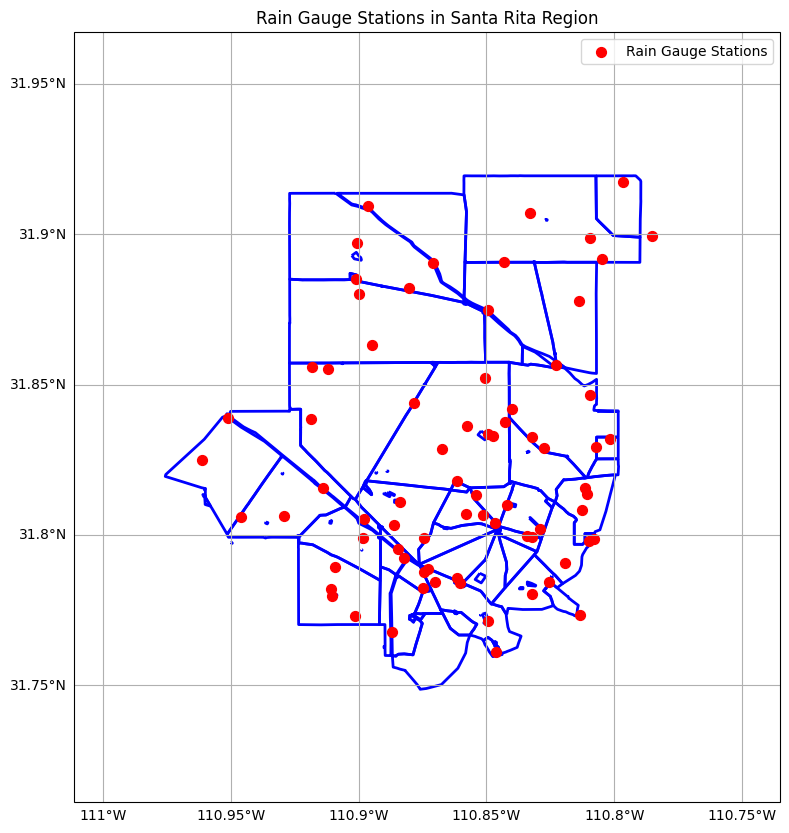

In [3]:
# Import the data
santa_rita_file_path = "C:/Users/Xiuchen Lu/Desktop/PRISM-vs.-my-RAINge-Log/UTM Coordinates of Rain Gauge Stations.xlsx"
santa_rita_shapefile_path = "C:/Users/Xiuchen Lu/Desktop/PRISM-vs.-my-RAINge-Log/SRER_BASEMAP/SRER_BASEMAP.shp"

# Read the data
santa_rita_location = pd.read_excel(santa_rita_file_path)

# Transform the UTM coordinates to WGS84
utm_zone = 12
proj_utm = pyproj.Proj(proj='utm', zone=utm_zone, datum='NAD83')
proj_wgs84 = pyproj.Proj(proj='latlong', datum='WGS84')

# Transform the UTM coordinates to WGS84
lon, lat = pyproj.transform(proj_utm, proj_wgs84, santa_rita_location['X-COORD'].values, santa_rita_location['Y-COORD'].values)
geometry = [Point(xy) for xy in zip(lon, lat)]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(santa_rita_location, geometry=geometry, crs=proj_utm.srs)
gdf = gdf.to_crs(epsg=4326)

# Read the shapefile
santa_rita_shape = gpd.read_file(santa_rita_shapefile_path)

# Save the GeoDataFrame to a GeoJSON file
gdf.to_file(r"C:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\rain_gauge_stations.geojson", driver="GeoJSON")

# Print the GeoDataFrame
print(gdf.head())

""" Plot the rain gauge stations and the Santa Rita region"""
def plot_region():
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    santa_rita_shape.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='Santa Rita Region')
    ax.set_extent([lon.min() - 0.05, lon.max() + 0.05, lat.min() - 0.05, lat.max() + 0.05], crs=ccrs.PlateCarree())
    
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    
    
    ax.scatter(lon, lat, color='red', s=50, transform=ccrs.PlateCarree(), label='Rain Gauge Stations')
    

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    plt.legend()
    
    plt.title('Rain Gauge Stations in Santa Rita Region')
    plt.show()


plot_region()

In [26]:
# For test but Rain gauage stations are not shown
# Create a folium map
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=12)
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain', attr='Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner', attr='Stamen Toner').add_to(m)
folium.TileLayer('Stamen Watercolor', attr='Stamen Watercolor').add_to(m)

# Add the GeoJSON file
folium.GeoJson(santa_rita_shape.to_crs(epsg=4326)).add_to(m)

# Add the rain gauge stations
marker_cluster = MarkerCluster().add_to(m)
for idx, row in gdf.iterrows():
    try:
        folium.Marker(location=[row.geometry.y, row.geometry.x], popup=row['CURRENT STATION NAME']).add_to(marker_cluster) 
    except KeyError as e:
        print(f"KeyError: {e}")

# Add a layer control
folium.LayerControl().add_to(m)

# Save the map
m.save("santa_rita_map.html")
m

In [9]:
precipitation_file_path = "C:/Users/Xiuchen Lu/Desktop/PRISM-vs.-my-RAINge-Log/precip2024-04.csv"
precipitation = pd.read_csv(precipitation_file_path)
precipitation.head()

,STATION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,BOX,1922,-9999,-9999,-9999,-9999,-9999.0,30.0,284.0,272.0,192.0,46.0,0.0,57.0,NaN,NaN,NaN
1,DESST,1922,-9999,-9999,-9999,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999.0,38.0,0.0,58.0,NaN,NaN,NaN
2,ERIOP,1922,-9999,-9999,-9999,-9999,-9999.0,0.0,-9999.0,-9999.0,-9999.0,64.0,0.0,64.0,NaN,NaN,NaN
3,FLORI,1922,-9999,-9999,-9999,-9999,-9999.0,41.0,388.0,324.0,79.0,43.0,0.0,123.0,NaN,NaN,NaN
4,FORES,1922,-9999,-9999,-9999,-9999,-9999.0,40.0,479.0,406.0,81.0,55.0,0.0,178.0,NaN,NaN,NaN


In [10]:
# Data cleaning and replace -9999 with NaN
precipitation.replace(-9999, pd.NA, inplace=True)
print("After Cleaning:")
print(precipitation.head())

# Convert the data from wide to long format
precipitation_long = precipitation.melt(id_vars=['STATION', 'YEAR'],
                                        value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'],
                                        var_name='MONTH',
                                        value_name='PRECIPITATION')
print("Data Conversion: ")
print(precipitation_long.head())

# Calculate the average precipitation per month for each station
monthly_avg = precipitation_long.groupby(['STATION', 'MONTH'])['PRECIPITATION'].mean().reset_index()
monthly_avg.rename(columns={'PRECIPITATION': 'AVG_PRECIPITATION'}, inplace=True)
print("Average precipitation per month per site:")
print(monthly_avg.head())

# Use the average precipitation to fill the missing values
precipitation_long = pd.merge(precipitation_long, monthly_avg, on=['STATION', 'MONTH'], how='left')

# USe the average precipitation to fill the missing values
precipitation_long['PRECIPITATION'] = precipitation_long.apply(
    lambda row: row['AVG_PRECIPITATION'] if pd.isna(row['PRECIPITATION']) else row['PRECIPITATION'], axis=1)

# Drop the 'AVG_PRECIPITATION' column
precipitation_long.drop(columns=['AVG_PRECIPITATION'], inplace=True)

print("Flled Data:")
print(precipitation_long.head())

# Calculate the average precipitation per year for each station
average_precipitation_year = precipitation_long.groupby(['STATION', 'YEAR'])['PRECIPITATION'].mean().reset_index()
print("Average precipitation per site per year:")
print(average_precipitation_year.head(7))

# Calculate the average precipitation per month for each station and year
average_precipitation_month_year = precipitation_long.groupby(['STATION', 'YEAR', 'MONTH'])['PRECIPITATION'].mean().reset_index()
print("Average monthly precipitation per site per year:")
print(average_precipitation_month_year.head(7))

# Calculate the average precipitation per month
average_precipitation_month = precipitation_long.groupby('MONTH')['PRECIPITATION'].mean().reset_index()
print("Average precipitation per month for all sites:")
print(average_precipitation_month.head(7))

# Save as CSV files
average_precipitation_year.to_csv("C:/Users/Xiuchen Lu/Desktop/PRISM-vs.-my-RAINge-Log/precipitation_yearly.csv", index=False)
average_precipitation_month_year.to_csv("C:/Users/Xiuchen Lu/Desktop/PRISM-vs.-my-RAINge-Log/precipitation_yearly_monthly.csv", index=False)
average_precipitation_month.to_csv("C:/Users/Xiuchen Lu/Desktop/PRISM-vs.-my-RAINge-Log/precipitation_monthly.csv", index=False)

After Cleaning:
  STATION  YEAR   JAN   FEB   MAR   APR   MAY   JUN    JUL    AUG    SEP  \
0     BOX  1922  <NA>  <NA>  <NA>  <NA>  <NA>  30.0  284.0  272.0  192.0   
1   DESST  1922  <NA>  <NA>  <NA>  <NA>  <NA>   0.0   <NA>   <NA>   <NA>   
2   ERIOP  1922  <NA>  <NA>  <NA>  <NA>  <NA>   0.0   <NA>   <NA>   <NA>   
3   FLORI  1922  <NA>  <NA>  <NA>  <NA>  <NA>  41.0  388.0  324.0   79.0   
4   FORES  1922  <NA>  <NA>  <NA>  <NA>  <NA>  40.0  479.0  406.0   81.0   

    OCT  NOV    DEC  Unnamed: 14  Unnamed: 15 Unnamed: 16  
0  46.0  0.0   57.0          NaN          NaN         NaN  
1  38.0  0.0   58.0          NaN          NaN         NaN  
2  64.0  0.0   64.0          NaN          NaN         NaN  
3  43.0  0.0  123.0          NaN          NaN         NaN  
4  55.0  0.0  178.0          NaN          NaN         NaN  
Data Conversion: 
  STATION  YEAR MONTH PRECIPITATION
0     BOX  1922   JAN          <NA>
1   DESST  1922   JAN          <NA>
2   ERIOP  1922   JAN          <NA>
3   F

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score    


In [12]:
precipitation_long.shape

(34104, 4)

In [13]:
print(precipitation_long.isnull().sum())
dropna_precipitation_long = precipitation_long.dropna()
print(dropna_precipitation_long.isnull().sum())

STATION          0
YEAR             0
MONTH            0
PRECIPITATION    2
dtype: int64
STATION          0
YEAR             0
MONTH            0
PRECIPITATION    0
dtype: int64


In [14]:
# Create a Random Forest Regressor

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
feature = encoder.fit_transform(dropna_precipitation_long[['YEAR', 'MONTH','STATION']])

X = feature
y = dropna_precipitation_long['PRECIPITATION'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
# Make predictions for test
sample_data = pd.DataFrame({'YEAR': [2024], 'MONTH': ['AUG'], 'STATION': ['187']})
sample_feature = encoder.transform(sample_data)
sample_prediction = rf.predict(sample_feature)
print(f"Predicted precipitation: {sample_prediction[0]:.2f} mm")


Predicted precipitation: 266.83 mm


In [16]:
# for Deep Learning package
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import date, timedelta, datetime

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


C:\Users\Xiuchen Lu\AppData\Local\Temp\ipykernel_184028\1201398640.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


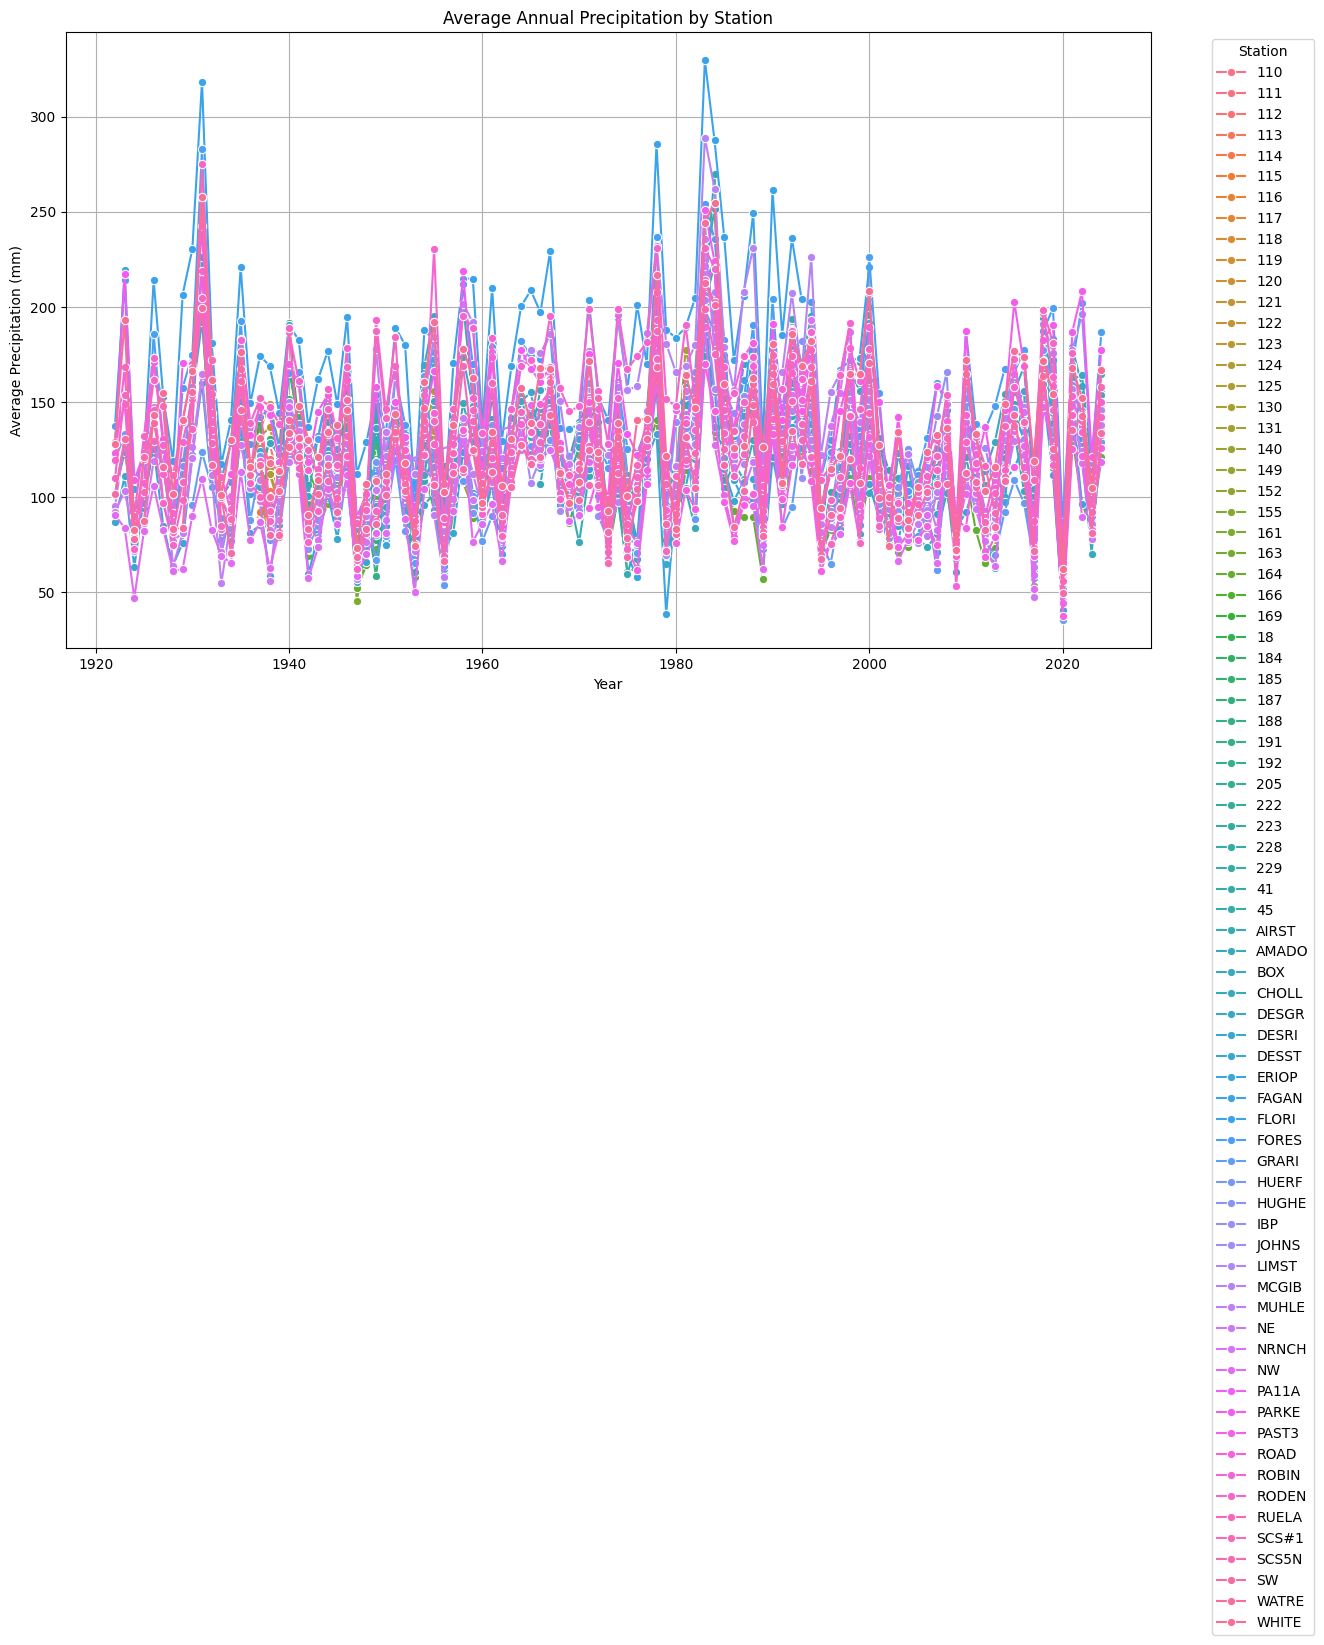

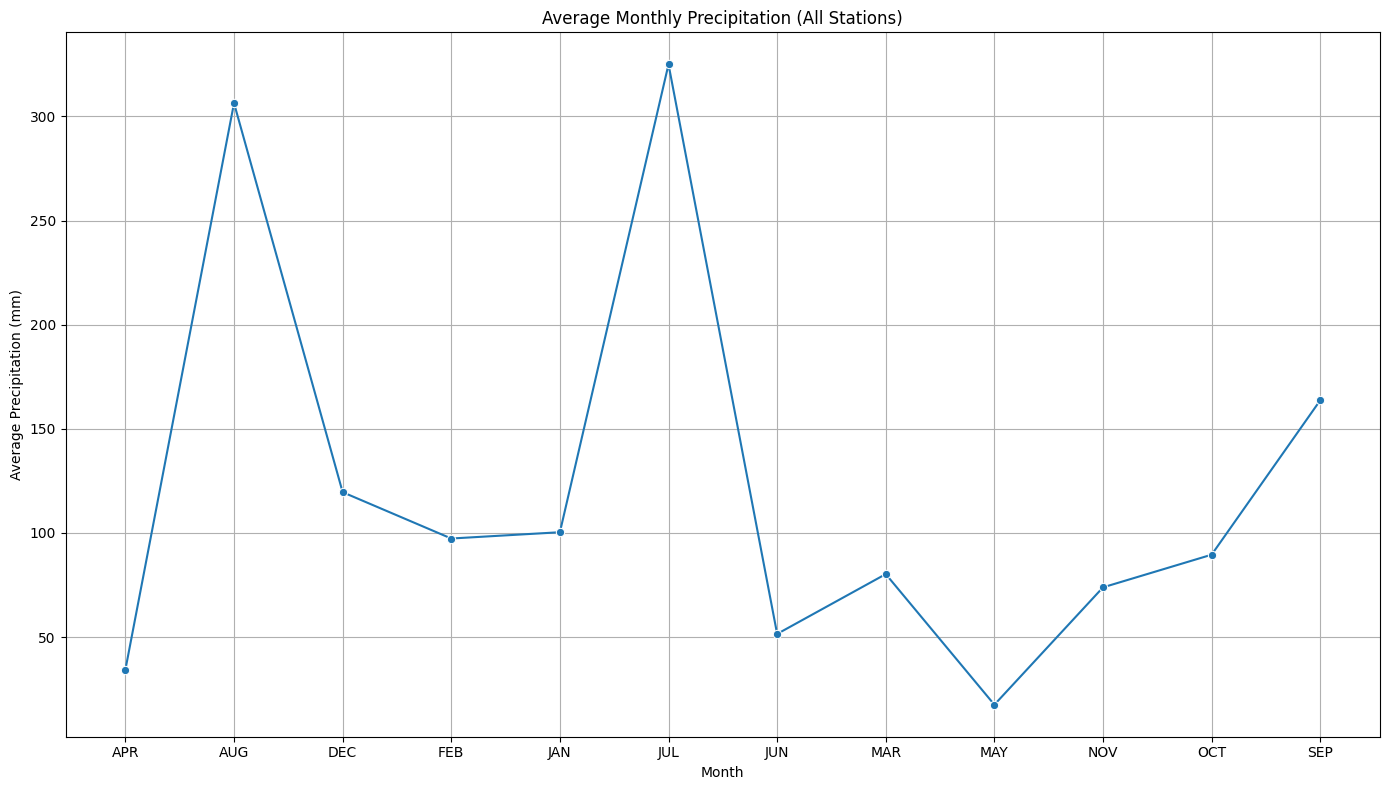

In [17]:
# Visualization for each station
plt.figure(figsize=(14, 8))
sns.lineplot(data=average_precipitation_year, x='YEAR', y='PRECIPITATION', hue='STATION', marker='o')
plt.title('Average Annual Precipitation by Station')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization of average monthly precipitation
plt.figure(figsize=(14, 8))
sns.lineplot(data=average_precipitation_month, x='MONTH', y='PRECIPITATION', marker='o')
plt.title('Average Monthly Precipitation (All Stations)')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
print(dropna_precipitation_long.head())
print(average_precipitation_month_year.head())

  STATION  YEAR MONTH  PRECIPITATION
0     BOX  1922   JAN     102.520000
1   DESST  1922   JAN      83.494949
2   ERIOP  1922   JAN      98.090909
3   FLORI  1922   JAN     158.844156
4   FORES  1922   JAN     124.310000
  STATION  YEAR MONTH  PRECIPITATION
0     110  1937   APR           25.0
1     110  1937   AUG          348.0
2     110  1937   DEC          122.0
3     110  1937   FEB          141.0
4     110  1937   JAN           87.0


In [25]:
average_precipitation_month_year['DATE'] = pd.to_datetime(average_precipitation_month_year['YEAR'].astype(str) + '-' + average_precipitation_month_year['MONTH'].astype(str) + '-01')
average_precipitation_month_year.set_index('DATE', inplace=True)

month_mapping = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 
                 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
average_precipitation_month_year['MONTH'] = average_precipitation_month_year['MONTH'].map(month_mapping)

stations = average_precipitation_month_year['STATION'].unique()

C:\Users\Xiuchen Lu\AppData\Local\Temp\ipykernel_184028\3939870310.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  average_precipitation_month_year['DATE'] = pd.to_datetime(average_precipitation_month_year['YEAR'].astype(str) + '-' + average_precipitation_month_year['MONTH'].astype(str) + '-01')


In [26]:
# define basic LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

        

In [38]:
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 2
num_epochs = 200

results = []
for station in stations:
    print(f'Processing station: {station}')
    
    # Get the data for the station
    station_data = average_precipitation_month_year[average_precipitation_month_year['STATION'] == station][['PRECIPITATION']].dropna()

    # Check if there is enough data
    if len(station_data) < 24:  # 24 months of data
        print(f'Skipping station {station} due to insufficient data')
        continue

    # Convert the data to a numpy array
    station_data = station_data.apply(pd.to_numeric, errors='coerce').dropna()

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(station_data.values.reshape(-1, 1))

    # Create the dataset
    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data) - time_step - 1):
            a = data[i:(i + time_step), 0]
            X.append(a)
            Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 12  
    X, y = create_dataset(scaled_data, time_step)
    print(X)
    print(y)

    # Split the data into training, validation, and test sets
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.2)
    test_size = len(X) - train_size - val_size
    X_train, X_val, X_test = X[0:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[0:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    # Convert the data to PyTorch tensors 
    X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, time_step, 1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, time_step, 1).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, time_step, 1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    # Create the model 
    model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # 
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Station: {station}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Make predictions 
    model.eval()
    train_predict = model(X_train).detach().cpu().numpy()
    val_predict = model(X_val).detach().cpu().numpy()
    test_predict = model(X_test).detach().cpu().numpy()

    # Inverse transform the predictions
    train_predict = scaler.inverse_transform(train_predict)
    val_predict = scaler.inverse_transform(val_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train = scaler.inverse_transform(y_train.cpu())
    y_val = scaler.inverse_transform(y_val.cpu())
    y_test = scaler.inverse_transform(y_test.cpu())

    # RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train) ** 2))
    val_rmse = np.sqrt(np.mean((val_predict - y_val) ** 2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))

    def calculate_accuarcy(y_true, y_pred, threshold = 10):

        correct = np.sum(np.abs(y_true - y_pred) < threshold)
        return correct / len(y_true)
    
    train_accuracy = calculate_accuarcy(y_train, train_predict, threshold=10)
    val_accuracy = calculate_accuarcy(y_val, val_predict, threshold=10)
    test_accuracy = calculate_accuarcy(y_test, test_predict, threshold=10)


    print(f'Station: {station}, Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}')
    print(f'Station: {station}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}')

    results.append({
        'station': station,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    })

Processing station: 110
[[0.05733945 0.79816514 0.27981651 0.3233945  0.19954128 0.79357798
  0.13302752 0.18348624 0.         0.         0.05045872 0.4587156 ]
 [0.79816514 0.27981651 0.3233945  0.19954128 0.79357798 0.13302752
  0.18348624 0.         0.         0.05045872 0.4587156  0.01376147]
 [0.27981651 0.3233945  0.19954128 0.79357798 0.13302752 0.18348624
  0.         0.         0.05045872 0.4587156  0.01376147 0.67431193]
 [0.3233945  0.19954128 0.79357798 0.13302752 0.18348624 0.
  0.         0.05045872 0.4587156  0.01376147 0.67431193 0.14678899]
 [0.19954128 0.79357798 0.13302752 0.18348624 0.         0.
  0.05045872 0.4587156  0.01376147 0.67431193 0.14678899 0.29816514]
 [0.79357798 0.13302752 0.18348624 0.         0.         0.05045872
  0.4587156  0.01376147 0.67431193 0.14678899 0.29816514 0.17889908]
 [0.13302752 0.18348624 0.         0.         0.05045872 0.4587156
  0.01376147 0.67431193 0.14678899 0.29816514 0.17889908 1.        ]
 [0.18348624 0.         0.        

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 110, Epoch [40/200], Loss: 0.0869, Val Loss: 0.1305
Station: 110, Epoch [50/200], Loss: 0.0859, Val Loss: 0.1284
Station: 110, Epoch [60/200], Loss: 0.0850, Val Loss: 0.1285
Station: 110, Epoch [70/200], Loss: 0.0840, Val Loss: 0.1275
Station: 110, Epoch [80/200], Loss: 0.0823, Val Loss: 0.1267
Station: 110, Epoch [90/200], Loss: 0.0782, Val Loss: 0.1252
Station: 110, Epoch [100/200], Loss: 0.0720, Val Loss: 0.1245
Station: 110, Epoch [110/200], Loss: 0.0668, Val Loss: 0.1265
Station: 110, Epoch [120/200], Loss: 0.0624, Val Loss: 0.1182
Station: 110, Epoch [130/200], Loss: 0.0605, Val Loss: 0.1142
Station: 110, Epoch [140/200], Loss: 0.0582, Val Loss: 0.1429
Station: 110, Epoch [150/200], Loss: 0.0525, Val Loss: 0.1160
Station: 110, Epoch [160/200], Loss: 0.0505, Val Loss: 0.1325
Station: 110, Epoch [170/200], Loss: 0.0426, Val Loss: 0.1366
Station: 110, Epoch [180/200], Loss: 0.0365, Val Loss: 0.2066
Station: 110, Epoch [190/200], Loss: 0.0630, Val Loss: 0.3052
Station: 110, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 111, Epoch [10/200], Loss: 0.1135, Val Loss: 0.1398
Station: 111, Epoch [20/200], Loss: 0.0977, Val Loss: 0.1366
Station: 111, Epoch [30/200], Loss: 0.0975, Val Loss: 0.1355
Station: 111, Epoch [40/200], Loss: 0.0966, Val Loss: 0.1359
Station: 111, Epoch [50/200], Loss: 0.0959, Val Loss: 0.1348
Station: 111, Epoch [60/200], Loss: 0.0952, Val Loss: 0.1348
Station: 111, Epoch [70/200], Loss: 0.0945, Val Loss: 0.1340
Station: 111, Epoch [80/200], Loss: 0.0935, Val Loss: 0.1335
Station: 111, Epoch [90/200], Loss: 0.0918, Val Loss: 0.1326
Station: 111, Epoch [100/200], Loss: 0.0883, Val Loss: 0.1318
Station: 111, Epoch [110/200], Loss: 0.0793, Val Loss: 0.1568
Station: 111, Epoch [120/200], Loss: 0.0729, Val Loss: 0.1247
Station: 111, Epoch [130/200], Loss: 0.0693, Val Loss: 0.1803
Station: 111, Epoch [140/200], Loss: 0.0707, Val Loss: 0.2419
Station: 111, Epoch [150/200], Loss: 0.0632, Val Loss: 0.1651
Station: 111, Epoch [160/200], Loss: 0.0662, Val Loss: 0.1223
Station: 111, Epo

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 112, Epoch [60/200], Loss: 0.0986, Val Loss: 0.1351
Station: 112, Epoch [70/200], Loss: 0.0965, Val Loss: 0.1344
Station: 112, Epoch [80/200], Loss: 0.0914, Val Loss: 0.1388
Station: 112, Epoch [90/200], Loss: 0.0842, Val Loss: 0.1637
Station: 112, Epoch [100/200], Loss: 0.0765, Val Loss: 0.1803
Station: 112, Epoch [110/200], Loss: 0.0707, Val Loss: 0.2974
Station: 112, Epoch [120/200], Loss: 0.0638, Val Loss: 0.2831
Station: 112, Epoch [130/200], Loss: 0.0546, Val Loss: 0.4466
Station: 112, Epoch [140/200], Loss: 0.0521, Val Loss: 0.5044
Station: 112, Epoch [150/200], Loss: 0.0495, Val Loss: 0.3146
Station: 112, Epoch [160/200], Loss: 0.0386, Val Loss: 0.5682
Station: 112, Epoch [170/200], Loss: 0.0308, Val Loss: 0.6036
Station: 112, Epoch [180/200], Loss: 0.0235, Val Loss: 0.9616
Station: 112, Epoch [190/200], Loss: 0.0169, Val Loss: 1.3232
Station: 112, Epoch [200/200], Loss: 0.0111, Val Loss: 1.4111
Station: 112, Train RMSE: 40.49266247919823, Validation RMSE: 465.65078253

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 113, Epoch [20/200], Loss: 0.0627, Val Loss: 0.1362
Station: 113, Epoch [30/200], Loss: 0.0622, Val Loss: 0.1343
Station: 113, Epoch [40/200], Loss: 0.0617, Val Loss: 0.1331
Station: 113, Epoch [50/200], Loss: 0.0611, Val Loss: 0.1342
Station: 113, Epoch [60/200], Loss: 0.0601, Val Loss: 0.1331
Station: 113, Epoch [70/200], Loss: 0.0585, Val Loss: 0.1326
Station: 113, Epoch [80/200], Loss: 0.0538, Val Loss: 0.1295
Station: 113, Epoch [90/200], Loss: 0.0490, Val Loss: 0.1120
Station: 113, Epoch [100/200], Loss: 0.0441, Val Loss: 0.1089
Station: 113, Epoch [110/200], Loss: 0.0416, Val Loss: 0.1170
Station: 113, Epoch [120/200], Loss: 0.0393, Val Loss: 0.1189
Station: 113, Epoch [130/200], Loss: 0.0373, Val Loss: 0.1033
Station: 113, Epoch [140/200], Loss: 0.0451, Val Loss: 0.0964
Station: 113, Epoch [150/200], Loss: 0.0418, Val Loss: 0.1040
Station: 113, Epoch [160/200], Loss: 0.0331, Val Loss: 0.0886
Station: 113, Epoch [170/200], Loss: 0.0306, Val Loss: 0.1171
Station: 113, Ep

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 114, Epoch [70/200], Loss: 0.0961, Val Loss: 0.1440
Station: 114, Epoch [80/200], Loss: 0.0929, Val Loss: 0.1420
Station: 114, Epoch [90/200], Loss: 0.0833, Val Loss: 0.1448
Station: 114, Epoch [100/200], Loss: 0.0768, Val Loss: 0.1166
Station: 114, Epoch [110/200], Loss: 0.0784, Val Loss: 0.1218
Station: 114, Epoch [120/200], Loss: 0.0732, Val Loss: 0.1202
Station: 114, Epoch [130/200], Loss: 0.0684, Val Loss: 0.1234
Station: 114, Epoch [140/200], Loss: 0.0628, Val Loss: 0.1272
Station: 114, Epoch [150/200], Loss: 0.0555, Val Loss: 0.1166
Station: 114, Epoch [160/200], Loss: 0.0462, Val Loss: 0.1194
Station: 114, Epoch [170/200], Loss: 0.0347, Val Loss: 0.1375
Station: 114, Epoch [180/200], Loss: 0.0242, Val Loss: 0.2935
Station: 114, Epoch [190/200], Loss: 0.0211, Val Loss: 0.4090
Station: 114, Epoch [200/200], Loss: 0.0143, Val Loss: 0.1669
Station: 114, Train RMSE: 52.831904866305216, Validation RMSE: 142.17177298747663, Test RMSE: 19.347357443091493
Station: 114, Train Ac

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 115, Epoch [30/200], Loss: 0.1107, Val Loss: 0.1314
Station: 115, Epoch [40/200], Loss: 0.1092, Val Loss: 0.1371
Station: 115, Epoch [50/200], Loss: 0.1081, Val Loss: 0.1315
Station: 115, Epoch [60/200], Loss: 0.1071, Val Loss: 0.1337
Station: 115, Epoch [70/200], Loss: 0.1061, Val Loss: 0.1311
Station: 115, Epoch [80/200], Loss: 0.1044, Val Loss: 0.1309
Station: 115, Epoch [90/200], Loss: 0.1007, Val Loss: 0.1303
Station: 115, Epoch [100/200], Loss: 0.0920, Val Loss: 0.1529
Station: 115, Epoch [110/200], Loss: 0.0902, Val Loss: 0.1171
Station: 115, Epoch [120/200], Loss: 0.0819, Val Loss: 0.1233
Station: 115, Epoch [130/200], Loss: 0.0758, Val Loss: 0.1328
Station: 115, Epoch [140/200], Loss: 0.0697, Val Loss: 0.1201
Station: 115, Epoch [150/200], Loss: 0.0645, Val Loss: 0.1289
Station: 115, Epoch [160/200], Loss: 0.0573, Val Loss: 0.1413
Station: 115, Epoch [170/200], Loss: 0.0511, Val Loss: 0.1474
Station: 115, Epoch [180/200], Loss: 0.0411, Val Loss: 0.1309
Station: 115, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 116, Epoch [60/200], Loss: 0.0852, Val Loss: 0.0981
Station: 116, Epoch [70/200], Loss: 0.0844, Val Loss: 0.0966
Station: 116, Epoch [80/200], Loss: 0.0829, Val Loss: 0.0969
Station: 116, Epoch [90/200], Loss: 0.0792, Val Loss: 0.0985
Station: 116, Epoch [100/200], Loss: 0.0727, Val Loss: 0.1434
Station: 116, Epoch [110/200], Loss: 0.0661, Val Loss: 0.0916
Station: 116, Epoch [120/200], Loss: 0.0685, Val Loss: 0.0993
Station: 116, Epoch [130/200], Loss: 0.0611, Val Loss: 0.1365
Station: 116, Epoch [140/200], Loss: 0.0550, Val Loss: 0.1339
Station: 116, Epoch [150/200], Loss: 0.0495, Val Loss: 0.1555
Station: 116, Epoch [160/200], Loss: 0.0436, Val Loss: 0.1912
Station: 116, Epoch [170/200], Loss: 0.0374, Val Loss: 0.1789
Station: 116, Epoch [180/200], Loss: 0.0320, Val Loss: 0.1864
Station: 116, Epoch [190/200], Loss: 0.0277, Val Loss: 0.1892
Station: 116, Epoch [200/200], Loss: 0.0203, Val Loss: 0.3120
Station: 116, Train RMSE: 49.12093450810765, Validation RMSE: 197.72960862

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 117, Epoch [10/200], Loss: 0.0704, Val Loss: 0.1018
Station: 117, Epoch [20/200], Loss: 0.0632, Val Loss: 0.0995
Station: 117, Epoch [30/200], Loss: 0.0631, Val Loss: 0.0991
Station: 117, Epoch [40/200], Loss: 0.0622, Val Loss: 0.0991
Station: 117, Epoch [50/200], Loss: 0.0618, Val Loss: 0.0986
Station: 117, Epoch [60/200], Loss: 0.0613, Val Loss: 0.0981
Station: 117, Epoch [70/200], Loss: 0.0605, Val Loss: 0.0974
Station: 117, Epoch [80/200], Loss: 0.0587, Val Loss: 0.0955
Station: 117, Epoch [90/200], Loss: 0.0528, Val Loss: 0.0880
Station: 117, Epoch [100/200], Loss: 0.0437, Val Loss: 0.1072
Station: 117, Epoch [110/200], Loss: 0.0475, Val Loss: 0.0766
Station: 117, Epoch [120/200], Loss: 0.0436, Val Loss: 0.0719
Station: 117, Epoch [130/200], Loss: 0.0361, Val Loss: 0.1307
Station: 117, Epoch [140/200], Loss: 0.0328, Val Loss: 0.0923
Station: 117, Epoch [150/200], Loss: 0.0280, Val Loss: 0.0974
Station: 117, Epoch [160/200], Loss: 0.0239, Val Loss: 0.1014
Station: 117, Epo

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 118, Epoch [60/200], Loss: 0.0567, Val Loss: 0.1063
Station: 118, Epoch [70/200], Loss: 0.0561, Val Loss: 0.1059
Station: 118, Epoch [80/200], Loss: 0.0550, Val Loss: 0.1049
Station: 118, Epoch [90/200], Loss: 0.0523, Val Loss: 0.1023
Station: 118, Epoch [100/200], Loss: 0.0430, Val Loss: 0.0987
Station: 118, Epoch [110/200], Loss: 0.0356, Val Loss: 0.1278
Station: 118, Epoch [120/200], Loss: 0.0323, Val Loss: 0.0941
Station: 118, Epoch [130/200], Loss: 0.0285, Val Loss: 0.1494
Station: 118, Epoch [140/200], Loss: 0.0263, Val Loss: 0.1179
Station: 118, Epoch [150/200], Loss: 0.0235, Val Loss: 0.1114
Station: 118, Epoch [160/200], Loss: 0.0214, Val Loss: 0.1102
Station: 118, Epoch [170/200], Loss: 0.0194, Val Loss: 0.1050
Station: 118, Epoch [180/200], Loss: 0.0174, Val Loss: 0.0991
Station: 118, Epoch [190/200], Loss: 0.0155, Val Loss: 0.0945
Station: 118, Epoch [200/200], Loss: 0.0138, Val Loss: 0.0894
Station: 118, Train RMSE: 38.833263016664674, Validation RMSE: 99.24675349

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 119, Epoch [30/200], Loss: 0.0748, Val Loss: 0.1067
Station: 119, Epoch [40/200], Loss: 0.0736, Val Loss: 0.1093
Station: 119, Epoch [50/200], Loss: 0.0728, Val Loss: 0.1068
Station: 119, Epoch [60/200], Loss: 0.0721, Val Loss: 0.1073
Station: 119, Epoch [70/200], Loss: 0.0711, Val Loss: 0.1060
Station: 119, Epoch [80/200], Loss: 0.0690, Val Loss: 0.1051
Station: 119, Epoch [90/200], Loss: 0.0623, Val Loss: 0.1092
Station: 119, Epoch [100/200], Loss: 0.0568, Val Loss: 0.2325
Station: 119, Epoch [110/200], Loss: 0.0519, Val Loss: 0.1098
Station: 119, Epoch [120/200], Loss: 0.0474, Val Loss: 0.2021
Station: 119, Epoch [130/200], Loss: 0.0418, Val Loss: 0.2644
Station: 119, Epoch [140/200], Loss: 0.0373, Val Loss: 0.3065
Station: 119, Epoch [150/200], Loss: 0.0327, Val Loss: 0.3004
Station: 119, Epoch [160/200], Loss: 0.0279, Val Loss: 0.2898
Station: 119, Epoch [170/200], Loss: 0.0240, Val Loss: 0.3457
Station: 119, Epoch [180/200], Loss: 0.0185, Val Loss: 0.2613
Station: 119, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 120, Epoch [90/200], Loss: 0.0614, Val Loss: 0.0834
Station: 120, Epoch [100/200], Loss: 0.0600, Val Loss: 0.0660
Station: 120, Epoch [110/200], Loss: 0.0476, Val Loss: 0.0933
Station: 120, Epoch [120/200], Loss: 0.0427, Val Loss: 0.0774
Station: 120, Epoch [130/200], Loss: 0.0368, Val Loss: 0.1491
Station: 120, Epoch [140/200], Loss: 0.0310, Val Loss: 0.1437
Station: 120, Epoch [150/200], Loss: 0.0252, Val Loss: 0.1289
Station: 120, Epoch [160/200], Loss: 0.0194, Val Loss: 0.1068
Station: 120, Epoch [170/200], Loss: 0.0129, Val Loss: 0.0880
Station: 120, Epoch [180/200], Loss: 0.0079, Val Loss: 0.0763
Station: 120, Epoch [190/200], Loss: 0.0065, Val Loss: 0.0764
Station: 120, Epoch [200/200], Loss: 0.0050, Val Loss: 0.0797
Station: 120, Train RMSE: 22.39079726047199, Validation RMSE: 90.08042871355028, Test RMSE: 65.942246240115
Station: 120, Train Accuracy: 0.9375, Validation Accuracy: 0.0, Test Accuracy: 0.0
Processing station: 121
[[0.05405405 0.66409266 0.2972973  0.28764

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 121, Epoch [50/200], Loss: 0.1078, Val Loss: 0.1120
Station: 121, Epoch [60/200], Loss: 0.1068, Val Loss: 0.1140
Station: 121, Epoch [70/200], Loss: 0.1058, Val Loss: 0.1116
Station: 121, Epoch [80/200], Loss: 0.1042, Val Loss: 0.1118
Station: 121, Epoch [90/200], Loss: 0.1012, Val Loss: 0.1122
Station: 121, Epoch [100/200], Loss: 0.0948, Val Loss: 0.1287
Station: 121, Epoch [110/200], Loss: 0.0883, Val Loss: 0.1351
Station: 121, Epoch [120/200], Loss: 0.0845, Val Loss: 0.1511
Station: 121, Epoch [130/200], Loss: 0.0808, Val Loss: 0.1498
Station: 121, Epoch [140/200], Loss: 0.0647, Val Loss: 0.1699
Station: 121, Epoch [150/200], Loss: 0.0518, Val Loss: 0.3338
Station: 121, Epoch [160/200], Loss: 0.0454, Val Loss: 0.5778
Station: 121, Epoch [170/200], Loss: 0.0194, Val Loss: 1.0026
Station: 121, Epoch [180/200], Loss: 0.0142, Val Loss: 1.1162
Station: 121, Epoch [190/200], Loss: 0.0134, Val Loss: 0.8861
Station: 121, Epoch [200/200], Loss: 0.0110, Val Loss: 0.9182
Station: 121,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 122, Epoch [20/200], Loss: 0.1243, Val Loss: 0.1196
Station: 122, Epoch [30/200], Loss: 0.1246, Val Loss: 0.1192
Station: 122, Epoch [40/200], Loss: 0.1234, Val Loss: 0.1246
Station: 122, Epoch [50/200], Loss: 0.1222, Val Loss: 0.1194
Station: 122, Epoch [60/200], Loss: 0.1207, Val Loss: 0.1218
Station: 122, Epoch [70/200], Loss: 0.1182, Val Loss: 0.1205
Station: 122, Epoch [80/200], Loss: 0.1130, Val Loss: 0.1246
Station: 122, Epoch [90/200], Loss: 0.1012, Val Loss: 0.1524
Station: 122, Epoch [100/200], Loss: 0.0899, Val Loss: 0.3725
Station: 122, Epoch [110/200], Loss: 0.0888, Val Loss: 0.1304
Station: 122, Epoch [120/200], Loss: 0.0786, Val Loss: 0.3412
Station: 122, Epoch [130/200], Loss: 0.0665, Val Loss: 0.2759
Station: 122, Epoch [140/200], Loss: 0.0837, Val Loss: 0.0851
Station: 122, Epoch [150/200], Loss: 0.0749, Val Loss: 0.4450
Station: 122, Epoch [160/200], Loss: 0.0542, Val Loss: 0.3559
Station: 122, Epoch [170/200], Loss: 0.0342, Val Loss: 0.7276
Station: 122, Ep

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 123, Epoch [80/200], Loss: 0.1164, Val Loss: 0.1384
Station: 123, Epoch [90/200], Loss: 0.1120, Val Loss: 0.1377
Station: 123, Epoch [100/200], Loss: 0.1006, Val Loss: 0.1653
Station: 123, Epoch [110/200], Loss: 0.0920, Val Loss: 0.1562
Station: 123, Epoch [120/200], Loss: 0.0848, Val Loss: 0.3142
Station: 123, Epoch [130/200], Loss: 0.0767, Val Loss: 0.5374
Station: 123, Epoch [140/200], Loss: 0.0644, Val Loss: 0.5626
Station: 123, Epoch [150/200], Loss: 0.0539, Val Loss: 0.6846
Station: 123, Epoch [160/200], Loss: 0.1177, Val Loss: 0.1161
Station: 123, Epoch [170/200], Loss: 0.0631, Val Loss: 0.5599
Station: 123, Epoch [180/200], Loss: 0.0578, Val Loss: 0.4242
Station: 123, Epoch [190/200], Loss: 0.0365, Val Loss: 0.8714
Station: 123, Epoch [200/200], Loss: 0.0330, Val Loss: 1.0704
Station: 123, Train RMSE: 63.59768125521206, Validation RMSE: 377.6336746468938, Test RMSE: 251.92458582881383
Station: 123, Train Accuracy: 0.3125, Validation Accuracy: 0.0, Test Accuracy: 0.6666

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 124, Epoch [50/200], Loss: 0.0774, Val Loss: 0.0994
Station: 124, Epoch [60/200], Loss: 0.0769, Val Loss: 0.0992
Station: 124, Epoch [70/200], Loss: 0.0764, Val Loss: 0.0984
Station: 124, Epoch [80/200], Loss: 0.0758, Val Loss: 0.0978
Station: 124, Epoch [90/200], Loss: 0.0746, Val Loss: 0.0971
Station: 124, Epoch [100/200], Loss: 0.0718, Val Loss: 0.1009
Station: 124, Epoch [110/200], Loss: 0.0637, Val Loss: 0.2597
Station: 124, Epoch [120/200], Loss: 0.0494, Val Loss: 0.3278
Station: 124, Epoch [130/200], Loss: 0.0825, Val Loss: 0.0906
Station: 124, Epoch [140/200], Loss: 0.0725, Val Loss: 0.1078
Station: 124, Epoch [150/200], Loss: 0.0695, Val Loss: 0.0922
Station: 124, Epoch [160/200], Loss: 0.0674, Val Loss: 0.1066
Station: 124, Epoch [170/200], Loss: 0.0652, Val Loss: 0.1093
Station: 124, Epoch [180/200], Loss: 0.0614, Val Loss: 0.1586
Station: 124, Epoch [190/200], Loss: 0.0552, Val Loss: 0.2723
Station: 124, Epoch [200/200], Loss: 0.0512, Val Loss: 0.4486
Station: 124,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 125, Epoch [20/200], Loss: 0.1068, Val Loss: 0.1114
Station: 125, Epoch [30/200], Loss: 0.1069, Val Loss: 0.1069
Station: 125, Epoch [40/200], Loss: 0.1053, Val Loss: 0.1118
Station: 125, Epoch [50/200], Loss: 0.1043, Val Loss: 0.1075
Station: 125, Epoch [60/200], Loss: 0.1033, Val Loss: 0.1076
Station: 125, Epoch [70/200], Loss: 0.1018, Val Loss: 0.1055
Station: 125, Epoch [80/200], Loss: 0.0994, Val Loss: 0.1042
Station: 125, Epoch [90/200], Loss: 0.0944, Val Loss: 0.1006
Station: 125, Epoch [100/200], Loss: 0.0789, Val Loss: 0.0756
Station: 125, Epoch [110/200], Loss: 0.0693, Val Loss: 0.0811
Station: 125, Epoch [120/200], Loss: 0.0583, Val Loss: 0.0669
Station: 125, Epoch [130/200], Loss: 0.0367, Val Loss: 0.0387
Station: 125, Epoch [140/200], Loss: 0.0210, Val Loss: 0.0644
Station: 125, Epoch [150/200], Loss: 0.0167, Val Loss: 0.0815
Station: 125, Epoch [160/200], Loss: 0.0159, Val Loss: 0.1055
Station: 125, Epoch [170/200], Loss: 0.0154, Val Loss: 0.0911
Station: 125, Ep

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([368, 1])) that is different to the input size (torch.Size([368, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([105, 1])) that is different to the input size (torch.Size([105, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 130, Epoch [40/200], Loss: 0.0219, Val Loss: 0.0256
Station: 130, Epoch [50/200], Loss: 0.0218, Val Loss: 0.0256
Station: 130, Epoch [60/200], Loss: 0.0217, Val Loss: 0.0255
Station: 130, Epoch [70/200], Loss: 0.0217, Val Loss: 0.0254
Station: 130, Epoch [80/200], Loss: 0.0216, Val Loss: 0.0253
Station: 130, Epoch [90/200], Loss: 0.0215, Val Loss: 0.0252
Station: 130, Epoch [100/200], Loss: 0.0214, Val Loss: 0.0251
Station: 130, Epoch [110/200], Loss: 0.0213, Val Loss: 0.0248
Station: 130, Epoch [120/200], Loss: 0.0212, Val Loss: 0.0246
Station: 130, Epoch [130/200], Loss: 0.0211, Val Loss: 0.0243
Station: 130, Epoch [140/200], Loss: 0.0209, Val Loss: 0.0237
Station: 130, Epoch [150/200], Loss: 0.0205, Val Loss: 0.0228
Station: 130, Epoch [160/200], Loss: 0.0202, Val Loss: 0.0221
Station: 130, Epoch [170/200], Loss: 0.0195, Val Loss: 0.0215
Station: 130, Epoch [180/200], Loss: 0.0192, Val Loss: 0.0206
Station: 130, Epoch [190/200], Loss: 0.0186, Val Loss: 0.0204
Station: 130, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([276, 1])) that is different to the input size (torch.Size([276, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([79, 1])) that is different to the input size (torch.Size([79, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 131, Epoch [10/200], Loss: 0.0212, Val Loss: 0.0205
Station: 131, Epoch [20/200], Loss: 0.0207, Val Loss: 0.0214
Station: 131, Epoch [30/200], Loss: 0.0205, Val Loss: 0.0206
Station: 131, Epoch [40/200], Loss: 0.0205, Val Loss: 0.0208
Station: 131, Epoch [50/200], Loss: 0.0204, Val Loss: 0.0207
Station: 131, Epoch [60/200], Loss: 0.0204, Val Loss: 0.0207
Station: 131, Epoch [70/200], Loss: 0.0203, Val Loss: 0.0207
Station: 131, Epoch [80/200], Loss: 0.0202, Val Loss: 0.0207
Station: 131, Epoch [90/200], Loss: 0.0201, Val Loss: 0.0207
Station: 131, Epoch [100/200], Loss: 0.0200, Val Loss: 0.0208
Station: 131, Epoch [110/200], Loss: 0.0199, Val Loss: 0.0209
Station: 131, Epoch [120/200], Loss: 0.0193, Val Loss: 0.0216
Station: 131, Epoch [130/200], Loss: 0.0189, Val Loss: 0.0208
Station: 131, Epoch [140/200], Loss: 0.0195, Val Loss: 0.0215
Station: 131, Epoch [150/200], Loss: 0.0190, Val Loss: 0.0208
Station: 131, Epoch [160/200], Loss: 0.0185, Val Loss: 0.0211
Station: 131, Epo

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([66, 1])) that is different to the input size (torch.Size([66, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([19, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 140, Epoch [80/200], Loss: 0.0473, Val Loss: 0.0214
Station: 140, Epoch [90/200], Loss: 0.0472, Val Loss: 0.0211
Station: 140, Epoch [100/200], Loss: 0.0470, Val Loss: 0.0209
Station: 140, Epoch [110/200], Loss: 0.0466, Val Loss: 0.0205
Station: 140, Epoch [120/200], Loss: 0.0461, Val Loss: 0.0198
Station: 140, Epoch [130/200], Loss: 0.0447, Val Loss: 0.0184
Station: 140, Epoch [140/200], Loss: 0.0437, Val Loss: 0.0192
Station: 140, Epoch [150/200], Loss: 0.0428, Val Loss: 0.0180
Station: 140, Epoch [160/200], Loss: 0.0418, Val Loss: 0.0178
Station: 140, Epoch [170/200], Loss: 0.0406, Val Loss: 0.0176
Station: 140, Epoch [180/200], Loss: 0.0389, Val Loss: 0.0177
Station: 140, Epoch [190/200], Loss: 0.0362, Val Loss: 0.0181
Station: 140, Epoch [200/200], Loss: 0.0325, Val Loss: 0.0177
Station: 140, Train RMSE: 122.31751445766378, Validation RMSE: 91.08264571696759, Test RMSE: 88.63871352170513
Station: 140, Train Accuracy: 0.22727272727272727, Validation Accuracy: 0.26315789473

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 149, Epoch [30/200], Loss: 0.0326, Val Loss: 0.0293
Station: 149, Epoch [40/200], Loss: 0.0324, Val Loss: 0.0307
Station: 149, Epoch [50/200], Loss: 0.0322, Val Loss: 0.0298
Station: 149, Epoch [60/200], Loss: 0.0322, Val Loss: 0.0298
Station: 149, Epoch [70/200], Loss: 0.0321, Val Loss: 0.0301
Station: 149, Epoch [80/200], Loss: 0.0320, Val Loss: 0.0299
Station: 149, Epoch [90/200], Loss: 0.0319, Val Loss: 0.0301
Station: 149, Epoch [100/200], Loss: 0.0317, Val Loss: 0.0301
Station: 149, Epoch [110/200], Loss: 0.0316, Val Loss: 0.0303
Station: 149, Epoch [120/200], Loss: 0.0314, Val Loss: 0.0305
Station: 149, Epoch [130/200], Loss: 0.0311, Val Loss: 0.0313
Station: 149, Epoch [140/200], Loss: 0.0306, Val Loss: 0.0325
Station: 149, Epoch [150/200], Loss: 0.0298, Val Loss: 0.0342
Station: 149, Epoch [160/200], Loss: 0.0281, Val Loss: 0.0456
Station: 149, Epoch [170/200], Loss: 0.0261, Val Loss: 0.0389
Station: 149, Epoch [180/200], Loss: 0.0248, Val Loss: 0.0277
Station: 149, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([108, 1])) that is different to the input size (torch.Size([108, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 152, Epoch [70/200], Loss: 0.0387, Val Loss: 0.0365
Station: 152, Epoch [80/200], Loss: 0.0386, Val Loss: 0.0366
Station: 152, Epoch [90/200], Loss: 0.0386, Val Loss: 0.0365
Station: 152, Epoch [100/200], Loss: 0.0385, Val Loss: 0.0366
Station: 152, Epoch [110/200], Loss: 0.0384, Val Loss: 0.0366
Station: 152, Epoch [120/200], Loss: 0.0383, Val Loss: 0.0366
Station: 152, Epoch [130/200], Loss: 0.0383, Val Loss: 0.0366
Station: 152, Epoch [140/200], Loss: 0.0382, Val Loss: 0.0367
Station: 152, Epoch [150/200], Loss: 0.0381, Val Loss: 0.0367
Station: 152, Epoch [160/200], Loss: 0.0380, Val Loss: 0.0367
Station: 152, Epoch [170/200], Loss: 0.0379, Val Loss: 0.0367
Station: 152, Epoch [180/200], Loss: 0.0379, Val Loss: 0.0368
Station: 152, Epoch [190/200], Loss: 0.0378, Val Loss: 0.0368
Station: 152, Epoch [200/200], Loss: 0.0377, Val Loss: 0.0369
Station: 152, Train RMSE: 128.56637172285008, Validation RMSE: 127.17591740155868, Test RMSE: 93.55432222873088
Station: 152, Train Acc

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 155, Epoch [30/200], Loss: 0.0547, Val Loss: 0.0376
Station: 155, Epoch [40/200], Loss: 0.0539, Val Loss: 0.0414
Station: 155, Epoch [50/200], Loss: 0.0536, Val Loss: 0.0387
Station: 155, Epoch [60/200], Loss: 0.0534, Val Loss: 0.0397
Station: 155, Epoch [70/200], Loss: 0.0532, Val Loss: 0.0395
Station: 155, Epoch [80/200], Loss: 0.0529, Val Loss: 0.0397
Station: 155, Epoch [90/200], Loss: 0.0526, Val Loss: 0.0396
Station: 155, Epoch [100/200], Loss: 0.0522, Val Loss: 0.0400
Station: 155, Epoch [110/200], Loss: 0.0516, Val Loss: 0.0406
Station: 155, Epoch [120/200], Loss: 0.0506, Val Loss: 0.0423
Station: 155, Epoch [130/200], Loss: 0.0488, Val Loss: 0.0462
Station: 155, Epoch [140/200], Loss: 0.0493, Val Loss: 0.0585
Station: 155, Epoch [150/200], Loss: 0.0469, Val Loss: 0.0394
Station: 155, Epoch [160/200], Loss: 0.0456, Val Loss: 0.0545
Station: 155, Epoch [170/200], Loss: 0.0444, Val Loss: 0.0546
Station: 155, Epoch [180/200], Loss: 0.0432, Val Loss: 0.0424
Station: 155, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 161, Epoch [50/200], Loss: 0.0413, Val Loss: 0.0305
Station: 161, Epoch [60/200], Loss: 0.0412, Val Loss: 0.0316
Station: 161, Epoch [70/200], Loss: 0.0411, Val Loss: 0.0314
Station: 161, Epoch [80/200], Loss: 0.0410, Val Loss: 0.0315
Station: 161, Epoch [90/200], Loss: 0.0409, Val Loss: 0.0317
Station: 161, Epoch [100/200], Loss: 0.0407, Val Loss: 0.0321
Station: 161, Epoch [110/200], Loss: 0.0404, Val Loss: 0.0328
Station: 161, Epoch [120/200], Loss: 0.0399, Val Loss: 0.0340
Station: 161, Epoch [130/200], Loss: 0.0389, Val Loss: 0.0352
Station: 161, Epoch [140/200], Loss: 0.0373, Val Loss: 0.0456
Station: 161, Epoch [150/200], Loss: 0.0363, Val Loss: 0.0292
Station: 161, Epoch [160/200], Loss: 0.0348, Val Loss: 0.0365
Station: 161, Epoch [170/200], Loss: 0.0341, Val Loss: 0.0277
Station: 161, Epoch [180/200], Loss: 0.0331, Val Loss: 0.0275
Station: 161, Epoch [190/200], Loss: 0.0326, Val Loss: 0.0277
Station: 161, Epoch [200/200], Loss: 0.0321, Val Loss: 0.0294
Station: 161,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 163, Epoch [70/200], Loss: 0.0399, Val Loss: 0.0305
Station: 163, Epoch [80/200], Loss: 0.0397, Val Loss: 0.0309
Station: 163, Epoch [90/200], Loss: 0.0393, Val Loss: 0.0315
Station: 163, Epoch [100/200], Loss: 0.0387, Val Loss: 0.0326
Station: 163, Epoch [110/200], Loss: 0.0366, Val Loss: 0.0340
Station: 163, Epoch [120/200], Loss: 0.0385, Val Loss: 0.0267
Station: 163, Epoch [130/200], Loss: 0.0352, Val Loss: 0.0308
Station: 163, Epoch [140/200], Loss: 0.0338, Val Loss: 0.0364
Station: 163, Epoch [150/200], Loss: 0.0315, Val Loss: 0.0369
Station: 163, Epoch [160/200], Loss: 0.0301, Val Loss: 0.0341
Station: 163, Epoch [170/200], Loss: 0.0291, Val Loss: 0.0309
Station: 163, Epoch [180/200], Loss: 0.0284, Val Loss: 0.0303
Station: 163, Epoch [190/200], Loss: 0.0279, Val Loss: 0.0307
Station: 163, Epoch [200/200], Loss: 0.0276, Val Loss: 0.0314
Station: 163, Train RMSE: 92.90247060978398, Validation RMSE: 99.28022954993688, Test RMSE: 59.90368662053211
Station: 163, Train Accur

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([713, 1])) that is different to the input size (torch.Size([713, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([203, 1])) that is different to the input size (torch.Size([203, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 164, Epoch [10/200], Loss: 0.0204, Val Loss: 0.0191
Station: 164, Epoch [20/200], Loss: 0.0196, Val Loss: 0.0161
Station: 164, Epoch [30/200], Loss: 0.0197, Val Loss: 0.0161
Station: 164, Epoch [40/200], Loss: 0.0196, Val Loss: 0.0165
Station: 164, Epoch [50/200], Loss: 0.0195, Val Loss: 0.0162
Station: 164, Epoch [60/200], Loss: 0.0195, Val Loss: 0.0162
Station: 164, Epoch [70/200], Loss: 0.0195, Val Loss: 0.0163
Station: 164, Epoch [80/200], Loss: 0.0195, Val Loss: 0.0162
Station: 164, Epoch [90/200], Loss: 0.0195, Val Loss: 0.0162
Station: 164, Epoch [100/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epoch [110/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epoch [120/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epoch [130/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epoch [140/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epoch [150/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epoch [160/200], Loss: 0.0194, Val Loss: 0.0162
Station: 164, Epo

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 166, Epoch [80/200], Loss: 0.0373, Val Loss: 0.0282
Station: 166, Epoch [90/200], Loss: 0.0372, Val Loss: 0.0282
Station: 166, Epoch [100/200], Loss: 0.0371, Val Loss: 0.0283
Station: 166, Epoch [110/200], Loss: 0.0370, Val Loss: 0.0283
Station: 166, Epoch [120/200], Loss: 0.0368, Val Loss: 0.0285
Station: 166, Epoch [130/200], Loss: 0.0367, Val Loss: 0.0286
Station: 166, Epoch [140/200], Loss: 0.0365, Val Loss: 0.0288
Station: 166, Epoch [150/200], Loss: 0.0363, Val Loss: 0.0292
Station: 166, Epoch [160/200], Loss: 0.0360, Val Loss: 0.0300
Station: 166, Epoch [170/200], Loss: 0.0355, Val Loss: 0.0323
Station: 166, Epoch [180/200], Loss: 0.0348, Val Loss: 0.0356
Station: 166, Epoch [190/200], Loss: 0.0333, Val Loss: 0.0558
Station: 166, Epoch [200/200], Loss: 0.0323, Val Loss: 0.0478
Station: 166, Train RMSE: 125.69657666083897, Validation RMSE: 153.460876911727, Test RMSE: 85.27399143742551
Station: 166, Train Accuracy: 0.12087912087912088, Validation Accuracy: 0.0, Test Accu

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 169, Epoch [30/200], Loss: 0.0370, Val Loss: 0.0363
Station: 169, Epoch [40/200], Loss: 0.0368, Val Loss: 0.0371
Station: 169, Epoch [50/200], Loss: 0.0367, Val Loss: 0.0365
Station: 169, Epoch [60/200], Loss: 0.0367, Val Loss: 0.0366
Station: 169, Epoch [70/200], Loss: 0.0366, Val Loss: 0.0368
Station: 169, Epoch [80/200], Loss: 0.0366, Val Loss: 0.0367
Station: 169, Epoch [90/200], Loss: 0.0365, Val Loss: 0.0368
Station: 169, Epoch [100/200], Loss: 0.0364, Val Loss: 0.0368
Station: 169, Epoch [110/200], Loss: 0.0364, Val Loss: 0.0368
Station: 169, Epoch [120/200], Loss: 0.0363, Val Loss: 0.0369
Station: 169, Epoch [130/200], Loss: 0.0363, Val Loss: 0.0369
Station: 169, Epoch [140/200], Loss: 0.0362, Val Loss: 0.0370
Station: 169, Epoch [150/200], Loss: 0.0361, Val Loss: 0.0371
Station: 169, Epoch [160/200], Loss: 0.0360, Val Loss: 0.0372
Station: 169, Epoch [170/200], Loss: 0.0359, Val Loss: 0.0374
Station: 169, Epoch [180/200], Loss: 0.0358, Val Loss: 0.0378
Station: 169, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([158, 1])) that is different to the input size (torch.Size([158, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([45, 1])) that is different to the input size (torch.Size([45, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 18, Epoch [60/200], Loss: 0.0062, Val Loss: 0.0099
Station: 18, Epoch [70/200], Loss: 0.0062, Val Loss: 0.0099
Station: 18, Epoch [80/200], Loss: 0.0062, Val Loss: 0.0099
Station: 18, Epoch [90/200], Loss: 0.0062, Val Loss: 0.0099
Station: 18, Epoch [100/200], Loss: 0.0062, Val Loss: 0.0098
Station: 18, Epoch [110/200], Loss: 0.0062, Val Loss: 0.0098
Station: 18, Epoch [120/200], Loss: 0.0062, Val Loss: 0.0098
Station: 18, Epoch [130/200], Loss: 0.0062, Val Loss: 0.0098
Station: 18, Epoch [140/200], Loss: 0.0062, Val Loss: 0.0098
Station: 18, Epoch [150/200], Loss: 0.0062, Val Loss: 0.0098
Station: 18, Epoch [160/200], Loss: 0.0061, Val Loss: 0.0098
Station: 18, Epoch [170/200], Loss: 0.0061, Val Loss: 0.0098
Station: 18, Epoch [180/200], Loss: 0.0061, Val Loss: 0.0098
Station: 18, Epoch [190/200], Loss: 0.0061, Val Loss: 0.0098
Station: 18, Epoch [200/200], Loss: 0.0061, Val Loss: 0.0098
Station: 18, Train RMSE: 109.12112514545305, Validation RMSE: 138.65817108191314, Test RM

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([108, 1])) that is different to the input size (torch.Size([108, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 184, Epoch [20/200], Loss: 0.0644, Val Loss: 0.0430
Station: 184, Epoch [30/200], Loss: 0.0646, Val Loss: 0.0428
Station: 184, Epoch [40/200], Loss: 0.0642, Val Loss: 0.0465
Station: 184, Epoch [50/200], Loss: 0.0638, Val Loss: 0.0441
Station: 184, Epoch [60/200], Loss: 0.0635, Val Loss: 0.0451
Station: 184, Epoch [70/200], Loss: 0.0632, Val Loss: 0.0451
Station: 184, Epoch [80/200], Loss: 0.0627, Val Loss: 0.0456
Station: 184, Epoch [90/200], Loss: 0.0618, Val Loss: 0.0461
Station: 184, Epoch [100/200], Loss: 0.0600, Val Loss: 0.0474
Station: 184, Epoch [110/200], Loss: 0.0530, Val Loss: 0.0392
Station: 184, Epoch [120/200], Loss: 0.0520, Val Loss: 0.0617
Station: 184, Epoch [130/200], Loss: 0.0485, Val Loss: 0.0747
Station: 184, Epoch [140/200], Loss: 0.0459, Val Loss: 0.0482
Station: 184, Epoch [150/200], Loss: 0.0408, Val Loss: 0.0433
Station: 184, Epoch [160/200], Loss: 0.0377, Val Loss: 0.0437
Station: 184, Epoch [170/200], Loss: 0.0361, Val Loss: 0.0461
Station: 184, Ep

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 185, Epoch [50/200], Loss: 0.0520, Val Loss: 0.0254
Station: 185, Epoch [60/200], Loss: 0.0519, Val Loss: 0.0263
Station: 185, Epoch [70/200], Loss: 0.0518, Val Loss: 0.0264
Station: 185, Epoch [80/200], Loss: 0.0516, Val Loss: 0.0266
Station: 185, Epoch [90/200], Loss: 0.0513, Val Loss: 0.0271
Station: 185, Epoch [100/200], Loss: 0.0509, Val Loss: 0.0277
Station: 185, Epoch [110/200], Loss: 0.0502, Val Loss: 0.0289
Station: 185, Epoch [120/200], Loss: 0.0482, Val Loss: 0.0315
Station: 185, Epoch [130/200], Loss: 0.0543, Val Loss: 0.0235
Station: 185, Epoch [140/200], Loss: 0.0486, Val Loss: 0.0293
Station: 185, Epoch [150/200], Loss: 0.0490, Val Loss: 0.0283
Station: 185, Epoch [160/200], Loss: 0.0486, Val Loss: 0.0326
Station: 185, Epoch [170/200], Loss: 0.0478, Val Loss: 0.0297
Station: 185, Epoch [180/200], Loss: 0.0467, Val Loss: 0.0326
Station: 185, Epoch [190/200], Loss: 0.0451, Val Loss: 0.0330
Station: 185, Epoch [200/200], Loss: 0.0436, Val Loss: 0.0347
Station: 185,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 187, Epoch [10/200], Loss: 0.0532, Val Loss: 0.0261
Station: 187, Epoch [20/200], Loss: 0.0468, Val Loss: 0.0270
Station: 187, Epoch [30/200], Loss: 0.0475, Val Loss: 0.0261
Station: 187, Epoch [40/200], Loss: 0.0469, Val Loss: 0.0290
Station: 187, Epoch [50/200], Loss: 0.0465, Val Loss: 0.0268
Station: 187, Epoch [60/200], Loss: 0.0463, Val Loss: 0.0276
Station: 187, Epoch [70/200], Loss: 0.0462, Val Loss: 0.0275
Station: 187, Epoch [80/200], Loss: 0.0461, Val Loss: 0.0275
Station: 187, Epoch [90/200], Loss: 0.0459, Val Loss: 0.0276
Station: 187, Epoch [100/200], Loss: 0.0457, Val Loss: 0.0277
Station: 187, Epoch [110/200], Loss: 0.0454, Val Loss: 0.0277
Station: 187, Epoch [120/200], Loss: 0.0450, Val Loss: 0.0278
Station: 187, Epoch [130/200], Loss: 0.0443, Val Loss: 0.0279
Station: 187, Epoch [140/200], Loss: 0.0429, Val Loss: 0.0285
Station: 187, Epoch [150/200], Loss: 0.0402, Val Loss: 0.0294
Station: 187, Epoch [160/200], Loss: 0.0395, Val Loss: 0.0345
Station: 187, Epo

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 188, Epoch [60/200], Loss: 0.0799, Val Loss: 0.0509
Station: 188, Epoch [70/200], Loss: 0.0797, Val Loss: 0.0507
Station: 188, Epoch [80/200], Loss: 0.0794, Val Loss: 0.0510
Station: 188, Epoch [90/200], Loss: 0.0790, Val Loss: 0.0513
Station: 188, Epoch [100/200], Loss: 0.0784, Val Loss: 0.0521
Station: 188, Epoch [110/200], Loss: 0.0773, Val Loss: 0.0530
Station: 188, Epoch [120/200], Loss: 0.0741, Val Loss: 0.0563
Station: 188, Epoch [130/200], Loss: 0.0686, Val Loss: 0.0911
Station: 188, Epoch [140/200], Loss: 0.0693, Val Loss: 0.0743
Station: 188, Epoch [150/200], Loss: 0.0634, Val Loss: 0.0593
Station: 188, Epoch [160/200], Loss: 0.0594, Val Loss: 0.0633
Station: 188, Epoch [170/200], Loss: 0.0555, Val Loss: 0.0737
Station: 188, Epoch [180/200], Loss: 0.0526, Val Loss: 0.0701
Station: 188, Epoch [190/200], Loss: 0.0507, Val Loss: 0.0685
Station: 188, Epoch [200/200], Loss: 0.0496, Val Loss: 0.0648
Station: 188, Train RMSE: 99.64879168013346, Validation RMSE: 114.01500608

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 191, Epoch [30/200], Loss: 0.0656, Val Loss: 0.0637
Station: 191, Epoch [40/200], Loss: 0.0655, Val Loss: 0.0652
Station: 191, Epoch [50/200], Loss: 0.0652, Val Loss: 0.0634
Station: 191, Epoch [60/200], Loss: 0.0650, Val Loss: 0.0644
Station: 191, Epoch [70/200], Loss: 0.0647, Val Loss: 0.0635
Station: 191, Epoch [80/200], Loss: 0.0645, Val Loss: 0.0638
Station: 191, Epoch [90/200], Loss: 0.0642, Val Loss: 0.0633
Station: 191, Epoch [100/200], Loss: 0.0639, Val Loss: 0.0632
Station: 191, Epoch [110/200], Loss: 0.0634, Val Loss: 0.0629
Station: 191, Epoch [120/200], Loss: 0.0628, Val Loss: 0.0627
Station: 191, Epoch [130/200], Loss: 0.0618, Val Loss: 0.0619
Station: 191, Epoch [140/200], Loss: 0.0607, Val Loss: 0.0558
Station: 191, Epoch [150/200], Loss: 0.0573, Val Loss: 0.0543
Station: 191, Epoch [160/200], Loss: 0.0550, Val Loss: 0.0471
Station: 191, Epoch [170/200], Loss: 0.0537, Val Loss: 0.0448
Station: 191, Epoch [180/200], Loss: 0.0522, Val Loss: 0.0450
Station: 191, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 192, Epoch [80/200], Loss: 0.0548, Val Loss: 0.0721
Station: 192, Epoch [90/200], Loss: 0.0547, Val Loss: 0.0720
Station: 192, Epoch [100/200], Loss: 0.0546, Val Loss: 0.0718
Station: 192, Epoch [110/200], Loss: 0.0544, Val Loss: 0.0716
Station: 192, Epoch [120/200], Loss: 0.0543, Val Loss: 0.0714
Station: 192, Epoch [130/200], Loss: 0.0541, Val Loss: 0.0712
Station: 192, Epoch [140/200], Loss: 0.0539, Val Loss: 0.0710
Station: 192, Epoch [150/200], Loss: 0.0537, Val Loss: 0.0707
Station: 192, Epoch [160/200], Loss: 0.0535, Val Loss: 0.0705
Station: 192, Epoch [170/200], Loss: 0.0532, Val Loss: 0.0702
Station: 192, Epoch [180/200], Loss: 0.0529, Val Loss: 0.0700
Station: 192, Epoch [190/200], Loss: 0.0521, Val Loss: 0.0697
Station: 192, Epoch [200/200], Loss: 0.0508, Val Loss: 0.0728
Station: 192, Train RMSE: 116.27597044951689, Validation RMSE: 138.63741537611196, Test RMSE: 79.36075250743366
Station: 192, Train Accuracy: 0.0989010989010989, Validation Accuracy: 0.03846153846

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([301, 1])) that is different to the input size (torch.Size([301, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([86, 1])) that is different to the input size (torch.Size([86, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 205, Epoch [30/200], Loss: 0.0347, Val Loss: 0.0365
Station: 205, Epoch [40/200], Loss: 0.0342, Val Loss: 0.0345
Station: 205, Epoch [50/200], Loss: 0.0340, Val Loss: 0.0352
Station: 205, Epoch [60/200], Loss: 0.0339, Val Loss: 0.0349
Station: 205, Epoch [70/200], Loss: 0.0339, Val Loss: 0.0348
Station: 205, Epoch [80/200], Loss: 0.0338, Val Loss: 0.0349
Station: 205, Epoch [90/200], Loss: 0.0338, Val Loss: 0.0347
Station: 205, Epoch [100/200], Loss: 0.0337, Val Loss: 0.0348
Station: 205, Epoch [110/200], Loss: 0.0337, Val Loss: 0.0347
Station: 205, Epoch [120/200], Loss: 0.0336, Val Loss: 0.0347
Station: 205, Epoch [130/200], Loss: 0.0336, Val Loss: 0.0346
Station: 205, Epoch [140/200], Loss: 0.0335, Val Loss: 0.0346
Station: 205, Epoch [150/200], Loss: 0.0334, Val Loss: 0.0346
Station: 205, Epoch [160/200], Loss: 0.0333, Val Loss: 0.0347
Station: 205, Epoch [170/200], Loss: 0.0331, Val Loss: 0.0348
Station: 205, Epoch [180/200], Loss: 0.0329, Val Loss: 0.0351
Station: 205, E

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 222, Epoch [90/200], Loss: 0.0848, Val Loss: 0.1393
Station: 222, Epoch [100/200], Loss: 0.0839, Val Loss: 0.1401
Station: 222, Epoch [110/200], Loss: 0.0824, Val Loss: 0.1417
Station: 222, Epoch [120/200], Loss: 0.0797, Val Loss: 0.1449
Station: 222, Epoch [130/200], Loss: 0.0735, Val Loss: 0.1516
Station: 222, Epoch [140/200], Loss: 0.0715, Val Loss: 0.1531
Station: 222, Epoch [150/200], Loss: 0.0491, Val Loss: 0.1508
Station: 222, Epoch [160/200], Loss: 0.0300, Val Loss: 0.1345
Station: 222, Epoch [170/200], Loss: 0.0246, Val Loss: 0.1273
Station: 222, Epoch [180/200], Loss: 0.0195, Val Loss: 0.1156
Station: 222, Epoch [190/200], Loss: 0.0139, Val Loss: 0.1103
Station: 222, Epoch [200/200], Loss: 0.0085, Val Loss: 0.0927
Station: 222, Train RMSE: 30.153539666107648, Validation RMSE: 101.10809575547623, Test RMSE: 29.83373254209499
Station: 222, Train Accuracy: 0.5714285714285714, Validation Accuracy: 0.0, Test Accuracy: 0.0
Processing station: 223
[[0.30044843 1.         0.

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 223, Epoch [50/200], Loss: 0.0912, Val Loss: 0.0952
Station: 223, Epoch [60/200], Loss: 0.0902, Val Loss: 0.0954
Station: 223, Epoch [70/200], Loss: 0.0888, Val Loss: 0.0951
Station: 223, Epoch [80/200], Loss: 0.0866, Val Loss: 0.0959
Station: 223, Epoch [90/200], Loss: 0.0819, Val Loss: 0.0977
Station: 223, Epoch [100/200], Loss: 0.0571, Val Loss: 0.0924
Station: 223, Epoch [110/200], Loss: 0.0710, Val Loss: 0.1013
Station: 223, Epoch [120/200], Loss: 0.0609, Val Loss: 0.1093
Station: 223, Epoch [130/200], Loss: 0.0407, Val Loss: 0.0828
Station: 223, Epoch [140/200], Loss: 0.0372, Val Loss: 0.0776
Station: 223, Epoch [150/200], Loss: 0.0337, Val Loss: 0.0719
Station: 223, Epoch [160/200], Loss: 0.0286, Val Loss: 0.0752
Station: 223, Epoch [170/200], Loss: 0.0248, Val Loss: 0.0804
Station: 223, Epoch [180/200], Loss: 0.0208, Val Loss: 0.0724
Station: 223, Epoch [190/200], Loss: 0.0164, Val Loss: 0.0649
Station: 223, Epoch [200/200], Loss: 0.0105, Val Loss: 0.0731
Station: 223,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([11, 1])) that is different to the input size (torch.Size([11, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 228, Epoch [20/200], Loss: 0.0328, Val Loss: 0.0190
Station: 228, Epoch [30/200], Loss: 0.0330, Val Loss: 0.0190
Station: 228, Epoch [40/200], Loss: 0.0328, Val Loss: 0.0194
Station: 228, Epoch [50/200], Loss: 0.0326, Val Loss: 0.0190
Station: 228, Epoch [60/200], Loss: 0.0326, Val Loss: 0.0190
Station: 228, Epoch [70/200], Loss: 0.0325, Val Loss: 0.0191
Station: 228, Epoch [80/200], Loss: 0.0325, Val Loss: 0.0190
Station: 228, Epoch [90/200], Loss: 0.0324, Val Loss: 0.0190
Station: 228, Epoch [100/200], Loss: 0.0324, Val Loss: 0.0190
Station: 228, Epoch [110/200], Loss: 0.0323, Val Loss: 0.0190
Station: 228, Epoch [120/200], Loss: 0.0323, Val Loss: 0.0190
Station: 228, Epoch [130/200], Loss: 0.0322, Val Loss: 0.0190
Station: 228, Epoch [140/200], Loss: 0.0322, Val Loss: 0.0191
Station: 228, Epoch [150/200], Loss: 0.0321, Val Loss: 0.0191
Station: 228, Epoch [160/200], Loss: 0.0320, Val Loss: 0.0192
Station: 228, Epoch [170/200], Loss: 0.0320, Val Loss: 0.0194
Station: 228, Ep

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([66, 1])) that is different to the input size (torch.Size([66, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([19, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 229, Epoch [70/200], Loss: 0.0290, Val Loss: 0.0593
Station: 229, Epoch [80/200], Loss: 0.0289, Val Loss: 0.0592
Station: 229, Epoch [90/200], Loss: 0.0289, Val Loss: 0.0591
Station: 229, Epoch [100/200], Loss: 0.0289, Val Loss: 0.0589
Station: 229, Epoch [110/200], Loss: 0.0289, Val Loss: 0.0588
Station: 229, Epoch [120/200], Loss: 0.0288, Val Loss: 0.0587
Station: 229, Epoch [130/200], Loss: 0.0288, Val Loss: 0.0586
Station: 229, Epoch [140/200], Loss: 0.0288, Val Loss: 0.0584
Station: 229, Epoch [150/200], Loss: 0.0288, Val Loss: 0.0583
Station: 229, Epoch [160/200], Loss: 0.0288, Val Loss: 0.0582
Station: 229, Epoch [170/200], Loss: 0.0287, Val Loss: 0.0580
Station: 229, Epoch [180/200], Loss: 0.0287, Val Loss: 0.0579
Station: 229, Epoch [190/200], Loss: 0.0287, Val Loss: 0.0578
Station: 229, Epoch [200/200], Loss: 0.0287, Val Loss: 0.0577
Station: 229, Train RMSE: 165.97974057784768, Validation RMSE: 235.3223040335941, Test RMSE: 181.71583757934044
Station: 229, Train Acc

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([436, 1])) that is different to the input size (torch.Size([436, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([124, 1])) that is different to the input size (torch.Size([124, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 41, Epoch [30/200], Loss: 0.0226, Val Loss: 0.0186
Station: 41, Epoch [40/200], Loss: 0.0226, Val Loss: 0.0188
Station: 41, Epoch [50/200], Loss: 0.0225, Val Loss: 0.0186
Station: 41, Epoch [60/200], Loss: 0.0225, Val Loss: 0.0186
Station: 41, Epoch [70/200], Loss: 0.0225, Val Loss: 0.0187
Station: 41, Epoch [80/200], Loss: 0.0225, Val Loss: 0.0186
Station: 41, Epoch [90/200], Loss: 0.0225, Val Loss: 0.0187
Station: 41, Epoch [100/200], Loss: 0.0225, Val Loss: 0.0187
Station: 41, Epoch [110/200], Loss: 0.0225, Val Loss: 0.0187
Station: 41, Epoch [120/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [130/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [140/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [150/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [160/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [170/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [180/200], Loss: 0.0224, Val Loss: 0.0187
Station: 41, Epoch [190/200], L

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([738, 1])) that is different to the input size (torch.Size([738, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([211, 1])) that is different to the input size (torch.Size([211, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: 45, Epoch [70/200], Loss: 0.0116, Val Loss: 0.0149
Station: 45, Epoch [80/200], Loss: 0.0116, Val Loss: 0.0148
Station: 45, Epoch [90/200], Loss: 0.0116, Val Loss: 0.0148
Station: 45, Epoch [100/200], Loss: 0.0116, Val Loss: 0.0148
Station: 45, Epoch [110/200], Loss: 0.0116, Val Loss: 0.0148
Station: 45, Epoch [120/200], Loss: 0.0116, Val Loss: 0.0148
Station: 45, Epoch [130/200], Loss: 0.0116, Val Loss: 0.0147
Station: 45, Epoch [140/200], Loss: 0.0116, Val Loss: 0.0147
Station: 45, Epoch [150/200], Loss: 0.0115, Val Loss: 0.0147
Station: 45, Epoch [160/200], Loss: 0.0115, Val Loss: 0.0147
Station: 45, Epoch [170/200], Loss: 0.0115, Val Loss: 0.0147
Station: 45, Epoch [180/200], Loss: 0.0115, Val Loss: 0.0146
Station: 45, Epoch [190/200], Loss: 0.0115, Val Loss: 0.0146
Station: 45, Epoch [200/200], Loss: 0.0115, Val Loss: 0.0146
Station: 45, Train RMSE: 138.81806845827677, Validation RMSE: 156.4200028629832, Test RMSE: 150.77219216013168
Station: 45, Train Accuracy: 0.0745257

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: AIRST, Epoch [20/200], Loss: 0.0532, Val Loss: 0.0351
Station: AIRST, Epoch [30/200], Loss: 0.0534, Val Loss: 0.0349
Station: AIRST, Epoch [40/200], Loss: 0.0531, Val Loss: 0.0359
Station: AIRST, Epoch [50/200], Loss: 0.0527, Val Loss: 0.0346
Station: AIRST, Epoch [60/200], Loss: 0.0525, Val Loss: 0.0350
Station: AIRST, Epoch [70/200], Loss: 0.0523, Val Loss: 0.0344
Station: AIRST, Epoch [80/200], Loss: 0.0521, Val Loss: 0.0344
Station: AIRST, Epoch [90/200], Loss: 0.0520, Val Loss: 0.0340
Station: AIRST, Epoch [100/200], Loss: 0.0518, Val Loss: 0.0339
Station: AIRST, Epoch [110/200], Loss: 0.0516, Val Loss: 0.0335
Station: AIRST, Epoch [120/200], Loss: 0.0513, Val Loss: 0.0332
Station: AIRST, Epoch [130/200], Loss: 0.0510, Val Loss: 0.0328
Station: AIRST, Epoch [140/200], Loss: 0.0505, Val Loss: 0.0321
Station: AIRST, Epoch [150/200], Loss: 0.0495, Val Loss: 0.0307
Station: AIRST, Epoch [160/200], Loss: 0.0462, Val Loss: 0.0243
Station: AIRST, Epoch [170/200], Loss: 0.0462, V

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([486, 1])) that is different to the input size (torch.Size([486, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([139, 1])) that is different to the input size (torch.Size([139, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: AMADO, Epoch [70/200], Loss: 0.0202, Val Loss: 0.0173
Station: AMADO, Epoch [80/200], Loss: 0.0201, Val Loss: 0.0173
Station: AMADO, Epoch [90/200], Loss: 0.0201, Val Loss: 0.0173
Station: AMADO, Epoch [100/200], Loss: 0.0201, Val Loss: 0.0173
Station: AMADO, Epoch [110/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [120/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [130/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [140/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [150/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [160/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [170/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [180/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [190/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Epoch [200/200], Loss: 0.0201, Val Loss: 0.0172
Station: AMADO, Train RMSE: 132.27625772918188, Validation RMSE: 122.53502050898494, Test RMSE: 125.3811108

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: BOX, Epoch [40/200], Loss: 0.0158, Val Loss: 0.0141
Station: BOX, Epoch [50/200], Loss: 0.0158, Val Loss: 0.0139
Station: BOX, Epoch [60/200], Loss: 0.0158, Val Loss: 0.0138
Station: BOX, Epoch [70/200], Loss: 0.0157, Val Loss: 0.0139
Station: BOX, Epoch [80/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [90/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [100/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [110/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [120/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [130/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [140/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [150/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [160/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [170/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [180/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, Epoch [190/200], Loss: 0.0157, Val Loss: 0.0138
Station: BOX, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: CHOLL, Epoch [90/200], Loss: 0.0367, Val Loss: 0.0246
Station: CHOLL, Epoch [100/200], Loss: 0.0365, Val Loss: 0.0249
Station: CHOLL, Epoch [110/200], Loss: 0.0362, Val Loss: 0.0254
Station: CHOLL, Epoch [120/200], Loss: 0.0360, Val Loss: 0.0266
Station: CHOLL, Epoch [130/200], Loss: 0.0357, Val Loss: 0.0279
Station: CHOLL, Epoch [140/200], Loss: 0.0354, Val Loss: 0.0288
Station: CHOLL, Epoch [150/200], Loss: 0.0350, Val Loss: 0.0276
Station: CHOLL, Epoch [160/200], Loss: 0.0335, Val Loss: 0.0267
Station: CHOLL, Epoch [170/200], Loss: 0.0308, Val Loss: 0.0317
Station: CHOLL, Epoch [180/200], Loss: 0.0283, Val Loss: 0.0173
Station: CHOLL, Epoch [190/200], Loss: 0.0262, Val Loss: 0.0178
Station: CHOLL, Epoch [200/200], Loss: 0.0255, Val Loss: 0.0201
Station: CHOLL, Train RMSE: 98.55924168327074, Validation RMSE: 87.94073702756715, Test RMSE: 136.56174587439708
Station: CHOLL, Train Accuracy: 0.26373626373626374, Validation Accuracy: 0.07692307692307693, Test Accuracy: 0.42857142

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([772, 1])) that is different to the input size (torch.Size([772, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([220, 1])) that is different to the input size (torch.Size([220, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: DESGR, Epoch [50/200], Loss: 0.0120, Val Loss: 0.0131
Station: DESGR, Epoch [60/200], Loss: 0.0120, Val Loss: 0.0130
Station: DESGR, Epoch [70/200], Loss: 0.0120, Val Loss: 0.0130
Station: DESGR, Epoch [80/200], Loss: 0.0119, Val Loss: 0.0130
Station: DESGR, Epoch [90/200], Loss: 0.0119, Val Loss: 0.0130
Station: DESGR, Epoch [100/200], Loss: 0.0119, Val Loss: 0.0129
Station: DESGR, Epoch [110/200], Loss: 0.0119, Val Loss: 0.0129
Station: DESGR, Epoch [120/200], Loss: 0.0119, Val Loss: 0.0129
Station: DESGR, Epoch [130/200], Loss: 0.0118, Val Loss: 0.0128
Station: DESGR, Epoch [140/200], Loss: 0.0118, Val Loss: 0.0128
Station: DESGR, Epoch [150/200], Loss: 0.0117, Val Loss: 0.0127
Station: DESGR, Epoch [160/200], Loss: 0.0117, Val Loss: 0.0145
Station: DESGR, Epoch [170/200], Loss: 0.0115, Val Loss: 0.0126
Station: DESGR, Epoch [180/200], Loss: 0.0113, Val Loss: 0.0124
Station: DESGR, Epoch [190/200], Loss: 0.0109, Val Loss: 0.0123
Station: DESGR, Epoch [200/200], Loss: 0.0107

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([755, 1])) that is different to the input size (torch.Size([755, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([215, 1])) that is different to the input size (torch.Size([215, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: DESRI, Epoch [10/200], Loss: 0.0149, Val Loss: 0.0158
Station: DESRI, Epoch [20/200], Loss: 0.0142, Val Loss: 0.0137
Station: DESRI, Epoch [30/200], Loss: 0.0143, Val Loss: 0.0138
Station: DESRI, Epoch [40/200], Loss: 0.0142, Val Loss: 0.0139
Station: DESRI, Epoch [50/200], Loss: 0.0141, Val Loss: 0.0137
Station: DESRI, Epoch [60/200], Loss: 0.0141, Val Loss: 0.0137
Station: DESRI, Epoch [70/200], Loss: 0.0141, Val Loss: 0.0137
Station: DESRI, Epoch [80/200], Loss: 0.0141, Val Loss: 0.0137
Station: DESRI, Epoch [90/200], Loss: 0.0141, Val Loss: 0.0137
Station: DESRI, Epoch [100/200], Loss: 0.0141, Val Loss: 0.0136
Station: DESRI, Epoch [110/200], Loss: 0.0141, Val Loss: 0.0136
Station: DESRI, Epoch [120/200], Loss: 0.0141, Val Loss: 0.0136
Station: DESRI, Epoch [130/200], Loss: 0.0141, Val Loss: 0.0136
Station: DESRI, Epoch [140/200], Loss: 0.0141, Val Loss: 0.0136
Station: DESRI, Epoch [150/200], Loss: 0.0140, Val Loss: 0.0136
Station: DESRI, Epoch [160/200], Loss: 0.0140, Va

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: DESST, Epoch [60/200], Loss: 0.0141, Val Loss: 0.0143
Station: DESST, Epoch [70/200], Loss: 0.0141, Val Loss: 0.0144
Station: DESST, Epoch [80/200], Loss: 0.0141, Val Loss: 0.0143
Station: DESST, Epoch [90/200], Loss: 0.0141, Val Loss: 0.0143
Station: DESST, Epoch [100/200], Loss: 0.0141, Val Loss: 0.0143
Station: DESST, Epoch [110/200], Loss: 0.0141, Val Loss: 0.0143
Station: DESST, Epoch [120/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [130/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [140/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [150/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [160/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [170/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [180/200], Loss: 0.0140, Val Loss: 0.0143
Station: DESST, Epoch [190/200], Loss: 0.0140, Val Loss: 0.0142
Station: DESST, Epoch [200/200], Loss: 0.0140, Val Loss: 0.0142
Station: DESST, Train RMSE: 121.219019500935

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: ERIOP, Epoch [20/200], Loss: 0.0177, Val Loss: 0.0152
Station: ERIOP, Epoch [30/200], Loss: 0.0177, Val Loss: 0.0152
Station: ERIOP, Epoch [40/200], Loss: 0.0177, Val Loss: 0.0156
Station: ERIOP, Epoch [50/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [60/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [70/200], Loss: 0.0176, Val Loss: 0.0154
Station: ERIOP, Epoch [80/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [90/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [100/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [110/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [120/200], Loss: 0.0176, Val Loss: 0.0153
Station: ERIOP, Epoch [130/200], Loss: 0.0175, Val Loss: 0.0152
Station: ERIOP, Epoch [140/200], Loss: 0.0175, Val Loss: 0.0152
Station: ERIOP, Epoch [150/200], Loss: 0.0175, Val Loss: 0.0152
Station: ERIOP, Epoch [160/200], Loss: 0.0175, Val Loss: 0.0152
Station: ERIOP, Epoch [170/200], Loss: 0.0175, V

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([83, 1])) that is different to the input size (torch.Size([83, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: FAGAN, Epoch [70/200], Loss: 0.0466, Val Loss: 0.0665
Station: FAGAN, Epoch [80/200], Loss: 0.0466, Val Loss: 0.0665
Station: FAGAN, Epoch [90/200], Loss: 0.0466, Val Loss: 0.0663
Station: FAGAN, Epoch [100/200], Loss: 0.0465, Val Loss: 0.0663
Station: FAGAN, Epoch [110/200], Loss: 0.0465, Val Loss: 0.0662
Station: FAGAN, Epoch [120/200], Loss: 0.0465, Val Loss: 0.0662
Station: FAGAN, Epoch [130/200], Loss: 0.0464, Val Loss: 0.0661
Station: FAGAN, Epoch [140/200], Loss: 0.0464, Val Loss: 0.0661
Station: FAGAN, Epoch [150/200], Loss: 0.0464, Val Loss: 0.0661
Station: FAGAN, Epoch [160/200], Loss: 0.0464, Val Loss: 0.0661
Station: FAGAN, Epoch [170/200], Loss: 0.0463, Val Loss: 0.0661
Station: FAGAN, Epoch [180/200], Loss: 0.0463, Val Loss: 0.0662
Station: FAGAN, Epoch [190/200], Loss: 0.0462, Val Loss: 0.0664
Station: FAGAN, Epoch [200/200], Loss: 0.0462, Val Loss: 0.0667
Station: FAGAN, Train RMSE: 94.54797908962189, Validation RMSE: 113.66577595723011, Test RMSE: 121.56084128

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([654, 1])) that is different to the input size (torch.Size([654, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([187, 1])) that is different to the input size (torch.Size([187, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: FLORI, Epoch [30/200], Loss: 0.0281, Val Loss: 0.0359
Station: FLORI, Epoch [40/200], Loss: 0.0280, Val Loss: 0.0343
Station: FLORI, Epoch [50/200], Loss: 0.0279, Val Loss: 0.0353
Station: FLORI, Epoch [60/200], Loss: 0.0279, Val Loss: 0.0351
Station: FLORI, Epoch [70/200], Loss: 0.0279, Val Loss: 0.0349
Station: FLORI, Epoch [80/200], Loss: 0.0278, Val Loss: 0.0352
Station: FLORI, Epoch [90/200], Loss: 0.0278, Val Loss: 0.0350
Station: FLORI, Epoch [100/200], Loss: 0.0278, Val Loss: 0.0351
Station: FLORI, Epoch [110/200], Loss: 0.0278, Val Loss: 0.0351
Station: FLORI, Epoch [120/200], Loss: 0.0277, Val Loss: 0.0352
Station: FLORI, Epoch [130/200], Loss: 0.0277, Val Loss: 0.0352
Station: FLORI, Epoch [140/200], Loss: 0.0277, Val Loss: 0.0353
Station: FLORI, Epoch [150/200], Loss: 0.0277, Val Loss: 0.0353
Station: FLORI, Epoch [160/200], Loss: 0.0276, Val Loss: 0.0354
Station: FLORI, Epoch [170/200], Loss: 0.0276, Val Loss: 0.0355
Station: FLORI, Epoch [180/200], Loss: 0.0276, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: FORES, Epoch [70/200], Loss: 0.0200, Val Loss: 0.0197
Station: FORES, Epoch [80/200], Loss: 0.0200, Val Loss: 0.0197
Station: FORES, Epoch [90/200], Loss: 0.0200, Val Loss: 0.0197
Station: FORES, Epoch [100/200], Loss: 0.0200, Val Loss: 0.0197
Station: FORES, Epoch [110/200], Loss: 0.0199, Val Loss: 0.0197
Station: FORES, Epoch [120/200], Loss: 0.0199, Val Loss: 0.0196
Station: FORES, Epoch [130/200], Loss: 0.0199, Val Loss: 0.0196
Station: FORES, Epoch [140/200], Loss: 0.0199, Val Loss: 0.0196
Station: FORES, Epoch [150/200], Loss: 0.0199, Val Loss: 0.0196
Station: FORES, Epoch [160/200], Loss: 0.0199, Val Loss: 0.0196
Station: FORES, Epoch [170/200], Loss: 0.0199, Val Loss: 0.0196
Station: FORES, Epoch [180/200], Loss: 0.0199, Val Loss: 0.0195
Station: FORES, Epoch [190/200], Loss: 0.0199, Val Loss: 0.0195
Station: FORES, Epoch [200/200], Loss: 0.0198, Val Loss: 0.0195
Station: FORES, Train RMSE: 166.93583604334376, Validation RMSE: 165.46671080067648, Test RMSE: 175.6534475

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([788, 1])) that is different to the input size (torch.Size([788, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([225, 1])) that is different to the input size (torch.Size([225, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: GRARI, Epoch [30/200], Loss: 0.0222, Val Loss: 0.0209
Station: GRARI, Epoch [40/200], Loss: 0.0221, Val Loss: 0.0208
Station: GRARI, Epoch [50/200], Loss: 0.0220, Val Loss: 0.0206
Station: GRARI, Epoch [60/200], Loss: 0.0220, Val Loss: 0.0207
Station: GRARI, Epoch [70/200], Loss: 0.0220, Val Loss: 0.0206
Station: GRARI, Epoch [80/200], Loss: 0.0220, Val Loss: 0.0206
Station: GRARI, Epoch [90/200], Loss: 0.0219, Val Loss: 0.0206
Station: GRARI, Epoch [100/200], Loss: 0.0219, Val Loss: 0.0206
Station: GRARI, Epoch [110/200], Loss: 0.0219, Val Loss: 0.0206
Station: GRARI, Epoch [120/200], Loss: 0.0219, Val Loss: 0.0205
Station: GRARI, Epoch [130/200], Loss: 0.0219, Val Loss: 0.0205
Station: GRARI, Epoch [140/200], Loss: 0.0219, Val Loss: 0.0205
Station: GRARI, Epoch [150/200], Loss: 0.0219, Val Loss: 0.0205
Station: GRARI, Epoch [160/200], Loss: 0.0219, Val Loss: 0.0205
Station: GRARI, Epoch [170/200], Loss: 0.0219, Val Loss: 0.0204
Station: GRARI, Epoch [180/200], Loss: 0.0218, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: HUERF, Epoch [80/200], Loss: 0.0165, Val Loss: 0.0171
Station: HUERF, Epoch [90/200], Loss: 0.0165, Val Loss: 0.0171
Station: HUERF, Epoch [100/200], Loss: 0.0165, Val Loss: 0.0171
Station: HUERF, Epoch [110/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [120/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [130/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [140/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [150/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [160/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [170/200], Loss: 0.0165, Val Loss: 0.0170
Station: HUERF, Epoch [180/200], Loss: 0.0165, Val Loss: 0.0169
Station: HUERF, Epoch [190/200], Loss: 0.0165, Val Loss: 0.0169
Station: HUERF, Epoch [200/200], Loss: 0.0165, Val Loss: 0.0169
Station: HUERF, Train RMSE: 141.74346844325476, Validation RMSE: 143.73102068751047, Test RMSE: 150.91027691791464
Station: HUERF, Train Accuracy: 0.11214953271028037, Va

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: HUGHE, Epoch [40/200], Loss: 0.0129, Val Loss: 0.0103
Station: HUGHE, Epoch [50/200], Loss: 0.0128, Val Loss: 0.0096
Station: HUGHE, Epoch [60/200], Loss: 0.0128, Val Loss: 0.0097
Station: HUGHE, Epoch [70/200], Loss: 0.0127, Val Loss: 0.0098
Station: HUGHE, Epoch [80/200], Loss: 0.0127, Val Loss: 0.0097
Station: HUGHE, Epoch [90/200], Loss: 0.0127, Val Loss: 0.0098
Station: HUGHE, Epoch [100/200], Loss: 0.0127, Val Loss: 0.0097
Station: HUGHE, Epoch [110/200], Loss: 0.0126, Val Loss: 0.0097
Station: HUGHE, Epoch [120/200], Loss: 0.0126, Val Loss: 0.0097
Station: HUGHE, Epoch [130/200], Loss: 0.0126, Val Loss: 0.0097
Station: HUGHE, Epoch [140/200], Loss: 0.0125, Val Loss: 0.0098
Station: HUGHE, Epoch [150/200], Loss: 0.0125, Val Loss: 0.0098
Station: HUGHE, Epoch [160/200], Loss: 0.0124, Val Loss: 0.0098
Station: HUGHE, Epoch [170/200], Loss: 0.0124, Val Loss: 0.0098
Station: HUGHE, Epoch [180/200], Loss: 0.0123, Val Loss: 0.0098
Station: HUGHE, Epoch [190/200], Loss: 0.0122,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([444, 1])) that is different to the input size (torch.Size([444, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([127, 1])) that is different to the input size (torch.Size([127, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: IBP, Epoch [10/200], Loss: 0.0197, Val Loss: 0.0204
Station: IBP, Epoch [20/200], Loss: 0.0193, Val Loss: 0.0199
Station: IBP, Epoch [30/200], Loss: 0.0194, Val Loss: 0.0199
Station: IBP, Epoch [40/200], Loss: 0.0191, Val Loss: 0.0196
Station: IBP, Epoch [50/200], Loss: 0.0191, Val Loss: 0.0195
Station: IBP, Epoch [60/200], Loss: 0.0191, Val Loss: 0.0195
Station: IBP, Epoch [70/200], Loss: 0.0190, Val Loss: 0.0195
Station: IBP, Epoch [80/200], Loss: 0.0190, Val Loss: 0.0195
Station: IBP, Epoch [90/200], Loss: 0.0190, Val Loss: 0.0194
Station: IBP, Epoch [100/200], Loss: 0.0190, Val Loss: 0.0194
Station: IBP, Epoch [110/200], Loss: 0.0189, Val Loss: 0.0194
Station: IBP, Epoch [120/200], Loss: 0.0189, Val Loss: 0.0194
Station: IBP, Epoch [130/200], Loss: 0.0189, Val Loss: 0.0194
Station: IBP, Epoch [140/200], Loss: 0.0189, Val Loss: 0.0193
Station: IBP, Epoch [150/200], Loss: 0.0189, Val Loss: 0.0193
Station: IBP, Epoch [160/200], Loss: 0.0189, Val Loss: 0.0193
Station: IBP, Epo

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: JOHNS, Epoch [80/200], Loss: 0.0580, Val Loss: 0.0529
Station: JOHNS, Epoch [90/200], Loss: 0.0578, Val Loss: 0.0515
Station: JOHNS, Epoch [100/200], Loss: 0.0573, Val Loss: 0.0538
Station: JOHNS, Epoch [110/200], Loss: 0.0562, Val Loss: 0.0550
Station: JOHNS, Epoch [120/200], Loss: 0.0526, Val Loss: 0.0681
Station: JOHNS, Epoch [130/200], Loss: 0.0429, Val Loss: 0.1584
Station: JOHNS, Epoch [140/200], Loss: 0.0391, Val Loss: 0.1080
Station: JOHNS, Epoch [150/200], Loss: 0.0365, Val Loss: 0.0855
Station: JOHNS, Epoch [160/200], Loss: 0.0334, Val Loss: 0.0496
Station: JOHNS, Epoch [170/200], Loss: 0.0297, Val Loss: 0.0883
Station: JOHNS, Epoch [180/200], Loss: 0.0236, Val Loss: 0.0868
Station: JOHNS, Epoch [190/200], Loss: 0.0230, Val Loss: 0.0567
Station: JOHNS, Epoch [200/200], Loss: 0.0162, Val Loss: 0.1094
Station: JOHNS, Train RMSE: 38.0302458062797, Validation RMSE: 113.76377612166303, Test RMSE: 110.07106659125252
Station: JOHNS, Train Accuracy: 0.8571428571428571, Valid

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([604, 1])) that is different to the input size (torch.Size([604, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([172, 1])) that is different to the input size (torch.Size([172, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: LIMST, Epoch [60/200], Loss: 0.0179, Val Loss: 0.0166
Station: LIMST, Epoch [70/200], Loss: 0.0179, Val Loss: 0.0165
Station: LIMST, Epoch [80/200], Loss: 0.0179, Val Loss: 0.0165
Station: LIMST, Epoch [90/200], Loss: 0.0178, Val Loss: 0.0165
Station: LIMST, Epoch [100/200], Loss: 0.0178, Val Loss: 0.0165
Station: LIMST, Epoch [110/200], Loss: 0.0178, Val Loss: 0.0164
Station: LIMST, Epoch [120/200], Loss: 0.0178, Val Loss: 0.0164
Station: LIMST, Epoch [130/200], Loss: 0.0178, Val Loss: 0.0164
Station: LIMST, Epoch [140/200], Loss: 0.0178, Val Loss: 0.0164
Station: LIMST, Epoch [150/200], Loss: 0.0177, Val Loss: 0.0164
Station: LIMST, Epoch [160/200], Loss: 0.0177, Val Loss: 0.0164
Station: LIMST, Epoch [170/200], Loss: 0.0177, Val Loss: 0.0164
Station: LIMST, Epoch [180/200], Loss: 0.0177, Val Loss: 0.0163
Station: LIMST, Epoch [190/200], Loss: 0.0177, Val Loss: 0.0163
Station: LIMST, Epoch [200/200], Loss: 0.0177, Val Loss: 0.0163
Station: LIMST, Train RMSE: 128.801611516386

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([444, 1])) that is different to the input size (torch.Size([444, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([127, 1])) that is different to the input size (torch.Size([127, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: MCGIB, Epoch [40/200], Loss: 0.0343, Val Loss: 0.0356
Station: MCGIB, Epoch [50/200], Loss: 0.0343, Val Loss: 0.0361
Station: MCGIB, Epoch [60/200], Loss: 0.0342, Val Loss: 0.0356
Station: MCGIB, Epoch [70/200], Loss: 0.0342, Val Loss: 0.0359
Station: MCGIB, Epoch [80/200], Loss: 0.0342, Val Loss: 0.0358
Station: MCGIB, Epoch [90/200], Loss: 0.0341, Val Loss: 0.0359
Station: MCGIB, Epoch [100/200], Loss: 0.0341, Val Loss: 0.0359
Station: MCGIB, Epoch [110/200], Loss: 0.0341, Val Loss: 0.0359
Station: MCGIB, Epoch [120/200], Loss: 0.0340, Val Loss: 0.0360
Station: MCGIB, Epoch [130/200], Loss: 0.0340, Val Loss: 0.0360
Station: MCGIB, Epoch [140/200], Loss: 0.0340, Val Loss: 0.0361
Station: MCGIB, Epoch [150/200], Loss: 0.0339, Val Loss: 0.0363
Station: MCGIB, Epoch [160/200], Loss: 0.0339, Val Loss: 0.0365
Station: MCGIB, Epoch [170/200], Loss: 0.0339, Val Loss: 0.0366
Station: MCGIB, Epoch [180/200], Loss: 0.0338, Val Loss: 0.0368
Station: MCGIB, Epoch [190/200], Loss: 0.0336,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: MUHLE, Epoch [20/200], Loss: 0.0211, Val Loss: 0.0226
Station: MUHLE, Epoch [30/200], Loss: 0.0208, Val Loss: 0.0224
Station: MUHLE, Epoch [40/200], Loss: 0.0208, Val Loss: 0.0225
Station: MUHLE, Epoch [50/200], Loss: 0.0208, Val Loss: 0.0224
Station: MUHLE, Epoch [60/200], Loss: 0.0208, Val Loss: 0.0224
Station: MUHLE, Epoch [70/200], Loss: 0.0208, Val Loss: 0.0224
Station: MUHLE, Epoch [80/200], Loss: 0.0208, Val Loss: 0.0224
Station: MUHLE, Epoch [90/200], Loss: 0.0207, Val Loss: 0.0223
Station: MUHLE, Epoch [100/200], Loss: 0.0207, Val Loss: 0.0223
Station: MUHLE, Epoch [110/200], Loss: 0.0207, Val Loss: 0.0223
Station: MUHLE, Epoch [120/200], Loss: 0.0207, Val Loss: 0.0223
Station: MUHLE, Epoch [130/200], Loss: 0.0207, Val Loss: 0.0223
Station: MUHLE, Epoch [140/200], Loss: 0.0207, Val Loss: 0.0222
Station: MUHLE, Epoch [150/200], Loss: 0.0207, Val Loss: 0.0222
Station: MUHLE, Epoch [160/200], Loss: 0.0207, Val Loss: 0.0222
Station: MUHLE, Epoch [170/200], Loss: 0.0207, V

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([805, 1])) that is different to the input size (torch.Size([805, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([230, 1])) that is different to the input size (torch.Size([230, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: NE, Epoch [80/200], Loss: 0.0170, Val Loss: 0.0147
Station: NE, Epoch [90/200], Loss: 0.0170, Val Loss: 0.0147
Station: NE, Epoch [100/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [110/200], Loss: 0.0170, Val Loss: 0.0147
Station: NE, Epoch [120/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [130/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [140/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [150/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [160/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [170/200], Loss: 0.0170, Val Loss: 0.0146
Station: NE, Epoch [180/200], Loss: 0.0169, Val Loss: 0.0146
Station: NE, Epoch [190/200], Loss: 0.0169, Val Loss: 0.0146
Station: NE, Epoch [200/200], Loss: 0.0169, Val Loss: 0.0146
Station: NE, Train RMSE: 128.4549499098623, Validation RMSE: 119.2153810678572, Test RMSE: 142.64786857965242
Station: NE, Train Accuracy: 0.1093167701863354, Validation Accuracy: 0.12173913043478261, Test Acc

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([58, 1])) that is different to the input size (torch.Size([58, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: NRNCH, Epoch [30/200], Loss: 0.0450, Val Loss: 0.0772
Station: NRNCH, Epoch [40/200], Loss: 0.0446, Val Loss: 0.0726
Station: NRNCH, Epoch [50/200], Loss: 0.0442, Val Loss: 0.0756
Station: NRNCH, Epoch [60/200], Loss: 0.0441, Val Loss: 0.0739
Station: NRNCH, Epoch [70/200], Loss: 0.0440, Val Loss: 0.0743
Station: NRNCH, Epoch [80/200], Loss: 0.0439, Val Loss: 0.0742
Station: NRNCH, Epoch [90/200], Loss: 0.0438, Val Loss: 0.0741
Station: NRNCH, Epoch [100/200], Loss: 0.0437, Val Loss: 0.0740
Station: NRNCH, Epoch [110/200], Loss: 0.0435, Val Loss: 0.0740
Station: NRNCH, Epoch [120/200], Loss: 0.0432, Val Loss: 0.0737
Station: NRNCH, Epoch [130/200], Loss: 0.0427, Val Loss: 0.0733
Station: NRNCH, Epoch [140/200], Loss: 0.0420, Val Loss: 0.0729
Station: NRNCH, Epoch [150/200], Loss: 0.0408, Val Loss: 0.0740
Station: NRNCH, Epoch [160/200], Loss: 0.0408, Val Loss: 0.0800
Station: NRNCH, Epoch [170/200], Loss: 0.0401, Val Loss: 0.0757
Station: NRNCH, Epoch [180/200], Loss: 0.0398, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: NW, Epoch [10/200], Loss: 0.0182, Val Loss: 0.0194
Station: NW, Epoch [20/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [30/200], Loss: 0.0176, Val Loss: 0.0175
Station: NW, Epoch [40/200], Loss: 0.0175, Val Loss: 0.0177
Station: NW, Epoch [50/200], Loss: 0.0175, Val Loss: 0.0176
Station: NW, Epoch [60/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [70/200], Loss: 0.0175, Val Loss: 0.0176
Station: NW, Epoch [80/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [90/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [100/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [110/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [120/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [130/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [140/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [150/200], Loss: 0.0175, Val Loss: 0.0175
Station: NW, Epoch [160/200], Loss: 0.0175, Val Loss: 0.0174
Station: NW, Epoch [170/200], Los

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: PA11A, Epoch [60/200], Loss: 0.0419, Val Loss: 0.0233
Station: PA11A, Epoch [70/200], Loss: 0.0418, Val Loss: 0.0233
Station: PA11A, Epoch [80/200], Loss: 0.0416, Val Loss: 0.0232
Station: PA11A, Epoch [90/200], Loss: 0.0415, Val Loss: 0.0234
Station: PA11A, Epoch [100/200], Loss: 0.0413, Val Loss: 0.0233
Station: PA11A, Epoch [110/200], Loss: 0.0411, Val Loss: 0.0234
Station: PA11A, Epoch [120/200], Loss: 0.0409, Val Loss: 0.0236
Station: PA11A, Epoch [130/200], Loss: 0.0407, Val Loss: 0.0238
Station: PA11A, Epoch [140/200], Loss: 0.0404, Val Loss: 0.0243
Station: PA11A, Epoch [150/200], Loss: 0.0400, Val Loss: 0.0255
Station: PA11A, Epoch [160/200], Loss: 0.0390, Val Loss: 0.0291
Station: PA11A, Epoch [170/200], Loss: 0.0391, Val Loss: 0.0270
Station: PA11A, Epoch [180/200], Loss: 0.0378, Val Loss: 0.0292
Station: PA11A, Epoch [190/200], Loss: 0.0375, Val Loss: 0.0288
Station: PA11A, Epoch [200/200], Loss: 0.0371, Val Loss: 0.0307
Station: PA11A, Train RMSE: 122.597207468298

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: PARKE, Epoch [30/200], Loss: 0.0207, Val Loss: 0.0181
Station: PARKE, Epoch [40/200], Loss: 0.0206, Val Loss: 0.0184
Station: PARKE, Epoch [50/200], Loss: 0.0205, Val Loss: 0.0181
Station: PARKE, Epoch [60/200], Loss: 0.0205, Val Loss: 0.0181
Station: PARKE, Epoch [70/200], Loss: 0.0205, Val Loss: 0.0181
Station: PARKE, Epoch [80/200], Loss: 0.0205, Val Loss: 0.0181
Station: PARKE, Epoch [90/200], Loss: 0.0204, Val Loss: 0.0181
Station: PARKE, Epoch [100/200], Loss: 0.0204, Val Loss: 0.0180
Station: PARKE, Epoch [110/200], Loss: 0.0204, Val Loss: 0.0180
Station: PARKE, Epoch [120/200], Loss: 0.0204, Val Loss: 0.0180
Station: PARKE, Epoch [130/200], Loss: 0.0204, Val Loss: 0.0180
Station: PARKE, Epoch [140/200], Loss: 0.0203, Val Loss: 0.0180
Station: PARKE, Epoch [150/200], Loss: 0.0203, Val Loss: 0.0180
Station: PARKE, Epoch [160/200], Loss: 0.0203, Val Loss: 0.0179
Station: PARKE, Epoch [170/200], Loss: 0.0203, Val Loss: 0.0179
Station: PARKE, Epoch [180/200], Loss: 0.0202, 

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([444, 1])) that is different to the input size (torch.Size([444, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([127, 1])) that is different to the input size (torch.Size([127, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: PAST3, Epoch [70/200], Loss: 0.0242, Val Loss: 0.0271
Station: PAST3, Epoch [80/200], Loss: 0.0241, Val Loss: 0.0271
Station: PAST3, Epoch [90/200], Loss: 0.0241, Val Loss: 0.0270
Station: PAST3, Epoch [100/200], Loss: 0.0241, Val Loss: 0.0270
Station: PAST3, Epoch [110/200], Loss: 0.0241, Val Loss: 0.0269
Station: PAST3, Epoch [120/200], Loss: 0.0241, Val Loss: 0.0269
Station: PAST3, Epoch [130/200], Loss: 0.0240, Val Loss: 0.0268
Station: PAST3, Epoch [140/200], Loss: 0.0240, Val Loss: 0.0268
Station: PAST3, Epoch [150/200], Loss: 0.0240, Val Loss: 0.0267
Station: PAST3, Epoch [160/200], Loss: 0.0240, Val Loss: 0.0267
Station: PAST3, Epoch [170/200], Loss: 0.0240, Val Loss: 0.0266
Station: PAST3, Epoch [180/200], Loss: 0.0240, Val Loss: 0.0266
Station: PAST3, Epoch [190/200], Loss: 0.0239, Val Loss: 0.0266
Station: PAST3, Epoch [200/200], Loss: 0.0239, Val Loss: 0.0265
Station: PAST3, Train RMSE: 118.98795177371974, Validation RMSE: 125.24415252260494, Test RMSE: 119.9130662

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: ROAD, Epoch [40/200], Loss: 0.0180, Val Loss: 0.0211
Station: ROAD, Epoch [50/200], Loss: 0.0179, Val Loss: 0.0210
Station: ROAD, Epoch [60/200], Loss: 0.0179, Val Loss: 0.0210
Station: ROAD, Epoch [70/200], Loss: 0.0179, Val Loss: 0.0210
Station: ROAD, Epoch [80/200], Loss: 0.0179, Val Loss: 0.0210
Station: ROAD, Epoch [90/200], Loss: 0.0179, Val Loss: 0.0209
Station: ROAD, Epoch [100/200], Loss: 0.0179, Val Loss: 0.0209
Station: ROAD, Epoch [110/200], Loss: 0.0178, Val Loss: 0.0209
Station: ROAD, Epoch [120/200], Loss: 0.0178, Val Loss: 0.0209
Station: ROAD, Epoch [130/200], Loss: 0.0178, Val Loss: 0.0208
Station: ROAD, Epoch [140/200], Loss: 0.0178, Val Loss: 0.0208
Station: ROAD, Epoch [150/200], Loss: 0.0178, Val Loss: 0.0208
Station: ROAD, Epoch [160/200], Loss: 0.0178, Val Loss: 0.0208
Station: ROAD, Epoch [170/200], Loss: 0.0178, Val Loss: 0.0208
Station: ROAD, Epoch [180/200], Loss: 0.0178, Val Loss: 0.0207
Station: ROAD, Epoch [190/200], Loss: 0.0178, Val Loss: 0.020

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([654, 1])) that is different to the input size (torch.Size([654, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([187, 1])) that is different to the input size (torch.Size([187, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: ROBIN, Epoch [80/200], Loss: 0.0145, Val Loss: 0.0119
Station: ROBIN, Epoch [90/200], Loss: 0.0145, Val Loss: 0.0119
Station: ROBIN, Epoch [100/200], Loss: 0.0144, Val Loss: 0.0120
Station: ROBIN, Epoch [110/200], Loss: 0.0144, Val Loss: 0.0121
Station: ROBIN, Epoch [120/200], Loss: 0.0143, Val Loss: 0.0121
Station: ROBIN, Epoch [130/200], Loss: 0.0142, Val Loss: 0.0122
Station: ROBIN, Epoch [140/200], Loss: 0.0137, Val Loss: 0.0121
Station: ROBIN, Epoch [150/200], Loss: 0.0130, Val Loss: 0.0113
Station: ROBIN, Epoch [160/200], Loss: 0.0124, Val Loss: 0.0106
Station: ROBIN, Epoch [170/200], Loss: 0.0119, Val Loss: 0.0108
Station: ROBIN, Epoch [180/200], Loss: 0.0118, Val Loss: 0.0099
Station: ROBIN, Epoch [190/200], Loss: 0.0116, Val Loss: 0.0101
Station: ROBIN, Epoch [200/200], Loss: 0.0114, Val Loss: 0.0098
Station: ROBIN, Train RMSE: 159.67550242496026, Validation RMSE: 148.11538212055362, Test RMSE: 159.65319970828537
Station: ROBIN, Train Accuracy: 0.09785932721712538, Va

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: RODEN, Epoch [40/200], Loss: 0.0127, Val Loss: 0.0130
Station: RODEN, Epoch [50/200], Loss: 0.0127, Val Loss: 0.0129
Station: RODEN, Epoch [60/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [70/200], Loss: 0.0126, Val Loss: 0.0129
Station: RODEN, Epoch [80/200], Loss: 0.0126, Val Loss: 0.0129
Station: RODEN, Epoch [90/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [100/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [110/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [120/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [130/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [140/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [150/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [160/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [170/200], Loss: 0.0126, Val Loss: 0.0128
Station: RODEN, Epoch [180/200], Loss: 0.0126, Val Loss: 0.0127
Station: RODEN, Epoch [190/200], Loss: 0.0126,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([839, 1])) that is different to the input size (torch.Size([839, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([239, 1])) that is different to the input size (torch.Size([239, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: RUELA, Epoch [80/200], Loss: 0.0112, Val Loss: 0.0096
Station: RUELA, Epoch [90/200], Loss: 0.0112, Val Loss: 0.0096
Station: RUELA, Epoch [100/200], Loss: 0.0112, Val Loss: 0.0096
Station: RUELA, Epoch [110/200], Loss: 0.0112, Val Loss: 0.0095
Station: RUELA, Epoch [120/200], Loss: 0.0112, Val Loss: 0.0095
Station: RUELA, Epoch [130/200], Loss: 0.0112, Val Loss: 0.0095
Station: RUELA, Epoch [140/200], Loss: 0.0112, Val Loss: 0.0095
Station: RUELA, Epoch [150/200], Loss: 0.0111, Val Loss: 0.0095
Station: RUELA, Epoch [160/200], Loss: 0.0111, Val Loss: 0.0095
Station: RUELA, Epoch [170/200], Loss: 0.0111, Val Loss: 0.0095
Station: RUELA, Epoch [180/200], Loss: 0.0111, Val Loss: 0.0095
Station: RUELA, Epoch [190/200], Loss: 0.0111, Val Loss: 0.0095
Station: RUELA, Epoch [200/200], Loss: 0.0111, Val Loss: 0.0095
Station: RUELA, Train RMSE: 155.28023902418542, Validation RMSE: 143.69646807906705, Test RMSE: 163.51209996273684
Station: RUELA, Train Accuracy: 0.10131108462455304, Va

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: SCS5N, Epoch [40/200], Loss: 0.0420, Val Loss: 0.0162
Station: SCS5N, Epoch [50/200], Loss: 0.0415, Val Loss: 0.0149
Station: SCS5N, Epoch [60/200], Loss: 0.0411, Val Loss: 0.0154
Station: SCS5N, Epoch [70/200], Loss: 0.0405, Val Loss: 0.0150
Station: SCS5N, Epoch [80/200], Loss: 0.0398, Val Loss: 0.0154
Station: SCS5N, Epoch [90/200], Loss: 0.0388, Val Loss: 0.0154
Station: SCS5N, Epoch [100/200], Loss: 0.0377, Val Loss: 0.0157
Station: SCS5N, Epoch [110/200], Loss: 0.0363, Val Loss: 0.0159
Station: SCS5N, Epoch [120/200], Loss: 0.0353, Val Loss: 0.0132
Station: SCS5N, Epoch [130/200], Loss: 0.0352, Val Loss: 0.0143
Station: SCS5N, Epoch [140/200], Loss: 0.0340, Val Loss: 0.0150
Station: SCS5N, Epoch [150/200], Loss: 0.0331, Val Loss: 0.0152
Station: SCS5N, Epoch [160/200], Loss: 0.0319, Val Loss: 0.0143
Station: SCS5N, Epoch [170/200], Loss: 0.0356, Val Loss: 0.0158
Station: SCS5N, Epoch [180/200], Loss: 0.0375, Val Loss: 0.0184
Station: SCS5N, Epoch [190/200], Loss: 0.0341,

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: SW, Epoch [10/200], Loss: 0.0170, Val Loss: 0.0146
Station: SW, Epoch [20/200], Loss: 0.0170, Val Loss: 0.0146
Station: SW, Epoch [30/200], Loss: 0.0169, Val Loss: 0.0146
Station: SW, Epoch [40/200], Loss: 0.0169, Val Loss: 0.0146
Station: SW, Epoch [50/200], Loss: 0.0169, Val Loss: 0.0145
Station: SW, Epoch [60/200], Loss: 0.0169, Val Loss: 0.0145
Station: SW, Epoch [70/200], Loss: 0.0168, Val Loss: 0.0144
Station: SW, Epoch [80/200], Loss: 0.0168, Val Loss: 0.0144
Station: SW, Epoch [90/200], Loss: 0.0168, Val Loss: 0.0144
Station: SW, Epoch [100/200], Loss: 0.0168, Val Loss: 0.0144
Station: SW, Epoch [110/200], Loss: 0.0168, Val Loss: 0.0143
Station: SW, Epoch [120/200], Loss: 0.0167, Val Loss: 0.0143
Station: SW, Epoch [130/200], Loss: 0.0167, Val Loss: 0.0142
Station: SW, Epoch [140/200], Loss: 0.0162, Val Loss: 0.0166
Station: SW, Epoch [150/200], Loss: 0.0162, Val Loss: 0.0135
Station: SW, Epoch [160/200], Loss: 0.0159, Val Loss: 0.0135
Station: SW, Epoch [170/200], Los

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([58, 1])) that is different to the input size (torch.Size([58, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: WATRE, Epoch [50/200], Loss: 0.0673, Val Loss: 0.0591
Station: WATRE, Epoch [60/200], Loss: 0.0668, Val Loss: 0.0590
Station: WATRE, Epoch [70/200], Loss: 0.0658, Val Loss: 0.0583
Station: WATRE, Epoch [80/200], Loss: 0.0626, Val Loss: 0.0565
Station: WATRE, Epoch [90/200], Loss: 0.0668, Val Loss: 0.0458
Station: WATRE, Epoch [100/200], Loss: 0.0535, Val Loss: 0.0509
Station: WATRE, Epoch [110/200], Loss: 0.0522, Val Loss: 0.0541
Station: WATRE, Epoch [120/200], Loss: 0.0497, Val Loss: 0.0491
Station: WATRE, Epoch [130/200], Loss: 0.0482, Val Loss: 0.0446
Station: WATRE, Epoch [140/200], Loss: 0.0472, Val Loss: 0.0445
Station: WATRE, Epoch [150/200], Loss: 0.0459, Val Loss: 0.0420
Station: WATRE, Epoch [160/200], Loss: 0.0445, Val Loss: 0.0406
Station: WATRE, Epoch [170/200], Loss: 0.0430, Val Loss: 0.0385
Station: WATRE, Epoch [180/200], Loss: 0.0413, Val Loss: 0.0368
Station: WATRE, Epoch [190/200], Loss: 0.0396, Val Loss: 0.0352
Station: WATRE, Epoch [200/200], Loss: 0.0380

c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([856, 1])) that is different to the input size (torch.Size([856, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Xiuchen Lu\Desktop\PRISM-vs.-my-RAINge-Log\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([244, 1])) that is different to the input size (torch.Size([244, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Station: WHITE, Epoch [10/200], Loss: 0.0146, Val Loss: 0.0146
Station: WHITE, Epoch [20/200], Loss: 0.0144, Val Loss: 0.0128
Station: WHITE, Epoch [30/200], Loss: 0.0144, Val Loss: 0.0127
Station: WHITE, Epoch [40/200], Loss: 0.0143, Val Loss: 0.0129
Station: WHITE, Epoch [50/200], Loss: 0.0142, Val Loss: 0.0126
Station: WHITE, Epoch [60/200], Loss: 0.0142, Val Loss: 0.0127
Station: WHITE, Epoch [70/200], Loss: 0.0142, Val Loss: 0.0127
Station: WHITE, Epoch [80/200], Loss: 0.0142, Val Loss: 0.0126
Station: WHITE, Epoch [90/200], Loss: 0.0142, Val Loss: 0.0126
Station: WHITE, Epoch [100/200], Loss: 0.0142, Val Loss: 0.0126
Station: WHITE, Epoch [110/200], Loss: 0.0142, Val Loss: 0.0126
Station: WHITE, Epoch [120/200], Loss: 0.0141, Val Loss: 0.0126
Station: WHITE, Epoch [130/200], Loss: 0.0141, Val Loss: 0.0126
Station: WHITE, Epoch [140/200], Loss: 0.0141, Val Loss: 0.0126
Station: WHITE, Epoch [150/200], Loss: 0.0141, Val Loss: 0.0126
Station: WHITE, Epoch [160/200], Loss: 0.0141, Va